## XI. RNNs

An RNN is a neural network which contains *recurrent layers*. A recurrent layer is a layer that can sequentially process a sequence of inputs.

RNNs can take all sorts of sequences as inputs. In this course, we will use them to process time series. But you can also use them to process other kinds of sequences, such as sentences.

In the following example, the RNN contains two recurrent layers, and one final dense layer (which serves as the output layer).

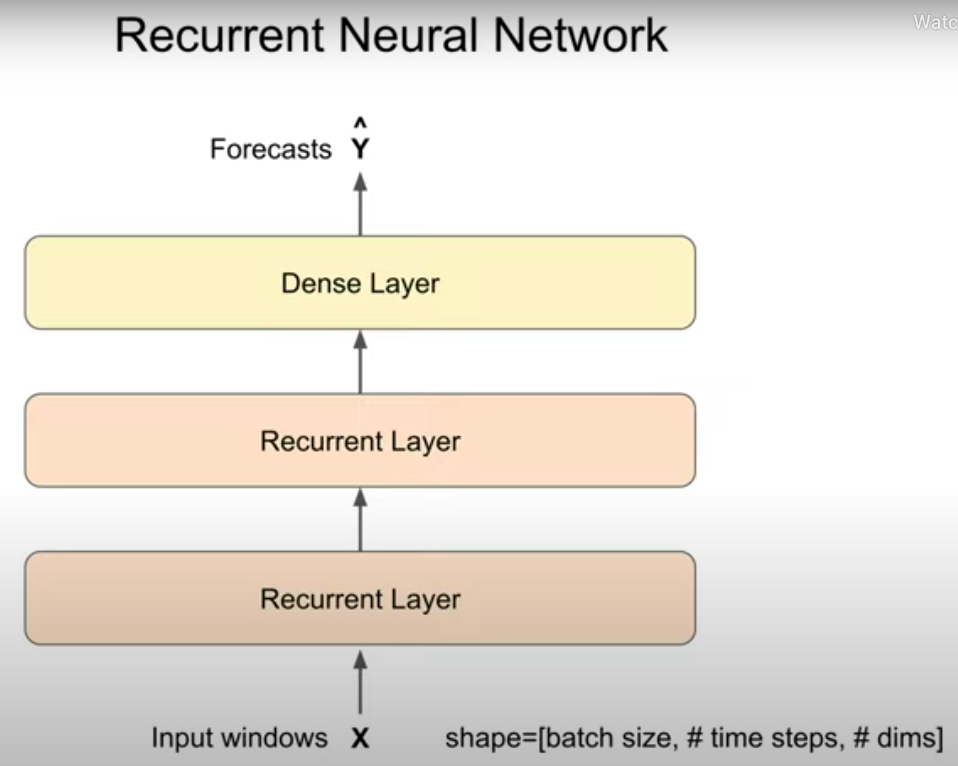

We feed it a batch of sequences (such as windows from a time series), and it will output a batch of forecasts (just like the previous models we trained).

However, one difference here is that the full input shape is 3 dimensional. The first dimension is the batch size, the second dimension represents the time steps, and the final dimension represents the dimensionality of the inputs at each time step. For example, if it's a univariate time series, then the last dimension is `1`. For a multivariate time series, the last dimension would be `2` or more.

**Note:** A batched dataset is a Python iterable comprising of tuples of tensors. For example, we can obtain one batch as follows:

```
for x, y in train_set.take(1):
    print(x.numpy())
    print(y.numpy())
```

The above paragraph is referring to the shape of `x`.

Our previous models had only 2 dimensional inputs: the batch dimension and a second dimension with all the input features (with one feature per time step, since we're dealing with a univariate time series).

$X$ in our previous models (batch size is `2`, # time steps is `4` and # dims is 1):

In [1]:
import numpy as np

x = np.array([[0, 1, 2, 3], [1, 2, 3, 4]])
x

array([[0, 1, 2, 3],
       [1, 2, 3, 4]])

In [2]:
x.shape

(2, 4)

$X$ adapted for RNNs:

In [3]:
x = np.array([[[0], [1], [2], [3]], [[1], [2], [3], [4]]])
x

array([[[0],
        [1],
        [2],
        [3]],

       [[1],
        [2],
        [3],
        [4]]])

In [4]:
x.shape

(2, 4, 1)

Let's zoom into one of these recurrent layers to see how it works.

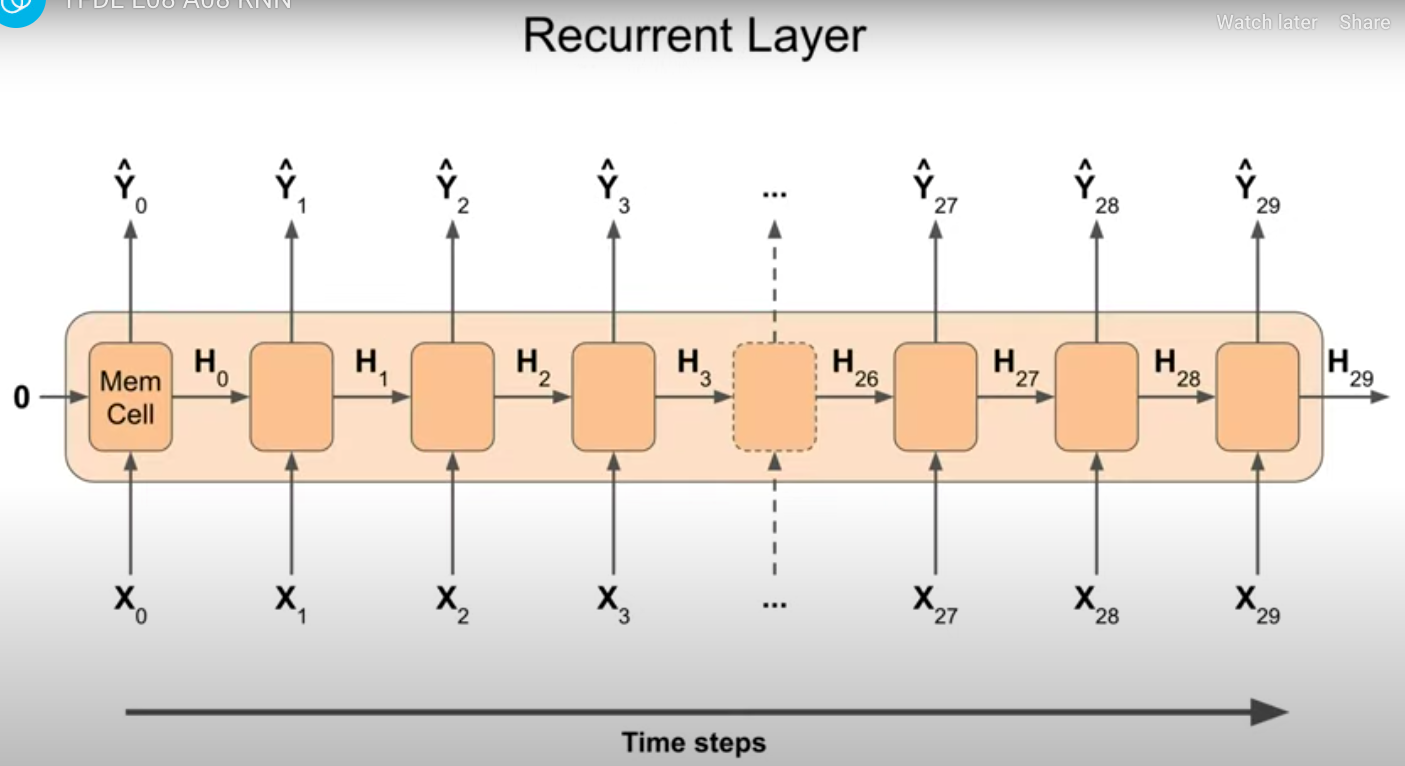

**Note:** The outputs $\hat{Y_0}, \hat{Y_1}, ...$ don't refer to the outputs of the full network. They refer to the outputs of the single recurrent layer shown above.

A recurrent layer is composed of a single *memory cell*, which is used repeatedly to compute the outputs (activations). A memory cell is basically a small neural network. It can be a simple dense layer, or a complex memory cell such as an LSTM cell or a GRU cell (as we will see later).

It's important to understand that a recurrent layer only contains a single cell. In the above diagram, you see multiple cells, but it's actually the same cell that  is reused multiple times by the layer.

At each time step, the memory cell takes the value of the input sequence **at that time step**, starting with $X_0, X_1, ...$, and it produces the output for that time step, starting with $\hat{Y_0}, \hat{Y_1}, ...$.

But the memory cell also produces another output at each time step, called a *state vector* (or sometimes a *context vector)*, starting with $H_0, H_1, ...$. As you can see, this state vector is fed as an additional input to the memory cell in the next time step. (So at time step $1$, the inputs are $X_1$ and $H_0$.) This is why this layer is called a recurrent layer. Part of the output of the memory cell at one time step is fed back to itself at the next time step.

**Note:** When the state vectors are collated into a batch, they become a *state matrix*.

It's a bit like when you're reading a sentence. As you're reading, you're focusing on one word at a time. But you also know the context of each word. And you are updating that context all the time (based on what you read). For example, if you read the sentence "He bowed to the queen.", when you read the word "queen", you immediately interpret it as referring to a monarch, because of the context your brain builds while reading the previous words. If instead, you read the sentence "The bees will die for the queen.", then you would know that the word "queen" refers to the queen of the beehive.

The beauty of this architecture is that it can handle sequences of any length using a constant number of parameters, viz. the parameters of the memory cell. (This is because at each time step, the memory cell is taking (i) the value of the sequence at that time step and (ii) the previous time step's context vector as inputs. It is NOT taking the entire sequence.)

As you may know, in theory, a neural network can approximate any continuous function (given it has enough neurons and you can train it properly). Similarly, if you have an RNN with big memory cells (i.e., with a lot of neurons), and you manage to train it successfully, you can, in theory, approximate any kind of algorithm (i.e., program). This makes it a very powerful beast (at least in theory). In practice, this would require a lot of training data, which you don't always have when you're dealing with, for example, low frequency time series. And unfortunately, RNNs are quite tricky to train. (They are somewhat unstable.)

## XII. Recurrent Layer

Let's go back to the recurrent layer, and take some time to understand the shape of the data that flows through it.

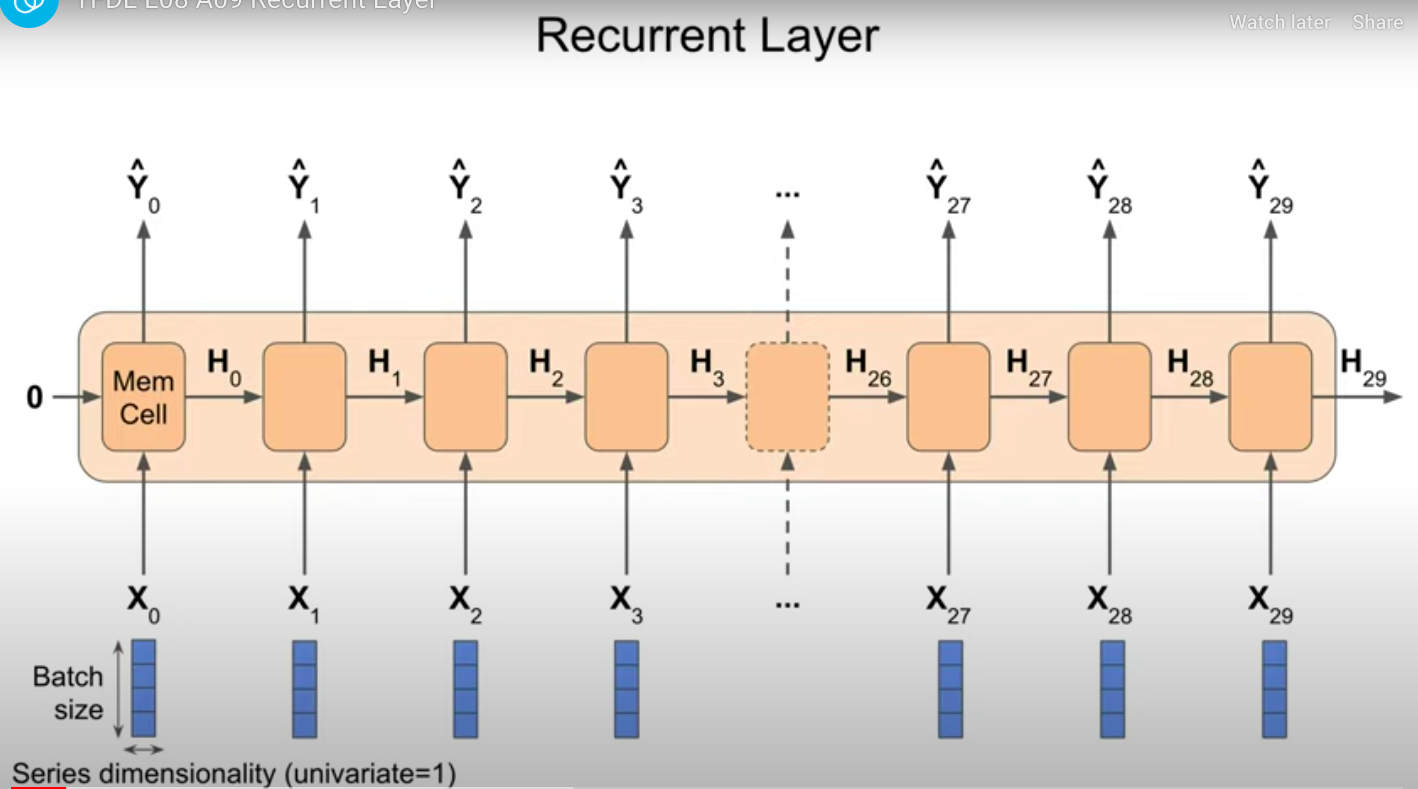

As I mentioned earlier, the inputs are 3 dimensional. In this example, I'm assuming that we're feeding a batch of `4` windows, each with `30` time steps. And since it's a univariate time series, there is a single value per time step. So the shape is `[4, 30, 1]`.

At each time step, the memory cell takes a matrix of shape `[4, 1]`, along with the state matrix from the previous time step.

Let's suppose the memory cell comprises of just `3` units.

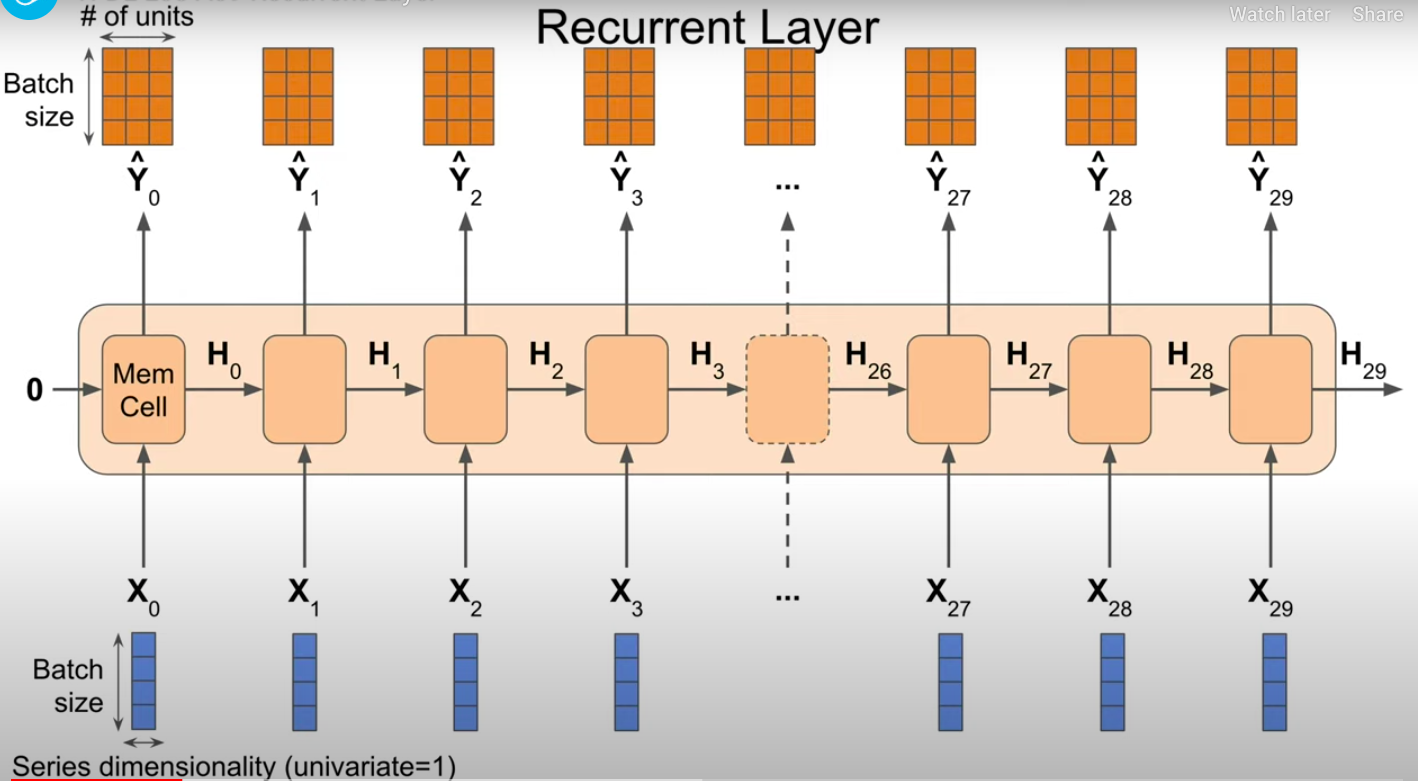

The output matrix at each time step will then have shape `[4, 3]`, because the batch size is `4` and the number of units is `3`.

**Note:** $(4 \times (1 + 3)) \times ((1 + 3) \times 3) = (4 \times 3)$. If it were a bivariate time series, then the matrix math would be $(4 \times (2 + 3)) \times ((2 + 3) \times 3) = (4 \times 3)$. We add $3$ to account for the output of the memory cell at the previous time step. So, the input matrix & the state matrix are being concatenated across `dim=1`.

**Alt:** The above is correct. But an easier way to think about it is the following: The $(4 \times 1)$ input matrix is being multiplied by a $(1 \times 3)$ weight matrix. This gives a $(4 \times 3)$ matrix. Now, the $(4 \times 3)$ state matrix (from the previous time step) is being multiplied by a $(3 \times 3)$ weight matrix. This gives another $(4 \times 3)$ matrix. Now, the two $(4 \times 3)$ matrices are being added. Finally, a couple of bias terms are added, and an activation function is applied.

From the <a href="https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html" target="_blank">documentation</a> of `nn.RNNCell`:

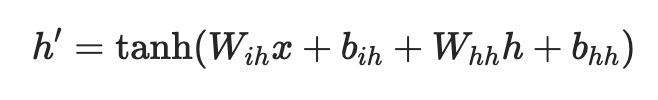

In other words, there are two `nn.Linear` layers inside an `nn.RNNCell` layer. In fact, this easier formulation is what's used by PyTorch's `nn.RNNCell`. (It maintains the following as separate parameter tensors: `weight_ih`, `weight_hh`, `bias_ih` and `bias_hh`.)

**Note:** `nn.RNN` is the multi-layer version of `nn.RNNCell` with a few additional options: `batch_first=False, dropout=0.0, bidirectional=False`. Due to these additional options, it's preferred over `nn.RNNCell`.

The equivalence of the two formulations is shown by the following math:

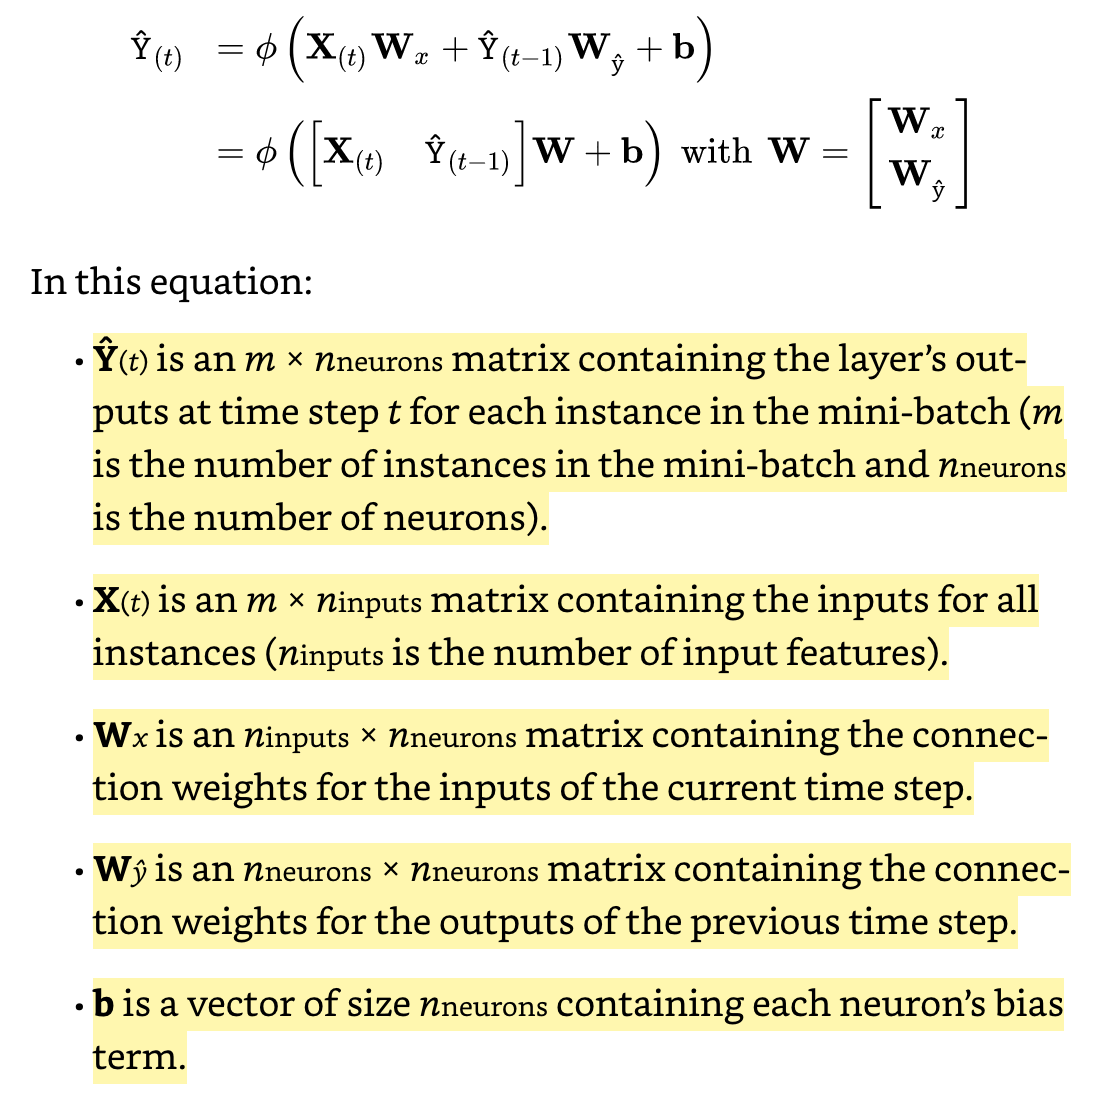

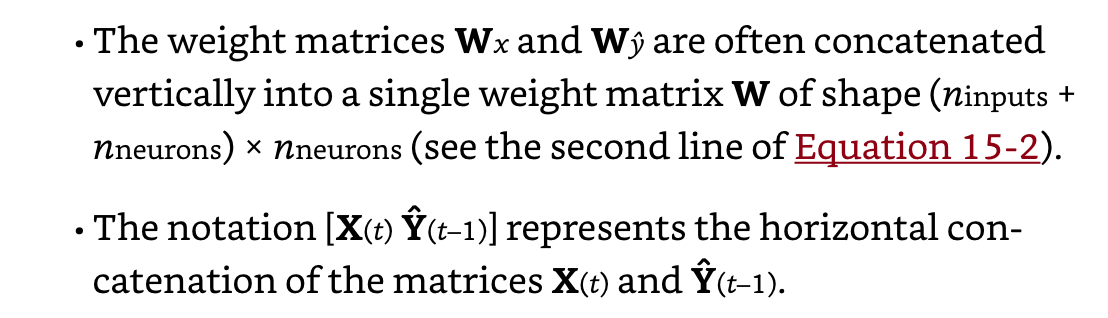

This means that the full output of the layer is 3 dimensional (just like the full input). The first dimension is the batch size (`4` in this case), the second dimension is the number of time steps (`30` in this case), and the third dimension is the output dimensionality, which is equal to the number of units (`3` in this case). So this layer will output a tensor of shape `[4, 30, 3]`. This output contains `4` multivariate time series (since the batch size is `4` and the output dimensionality is `3`), which can be passed on to another recurrent layer, and so on.

In a *simple RNN*, the memory cell is just a regular dense layer (illustrated in the matrix math above), and the state matrix is just a copy of the output matrix.

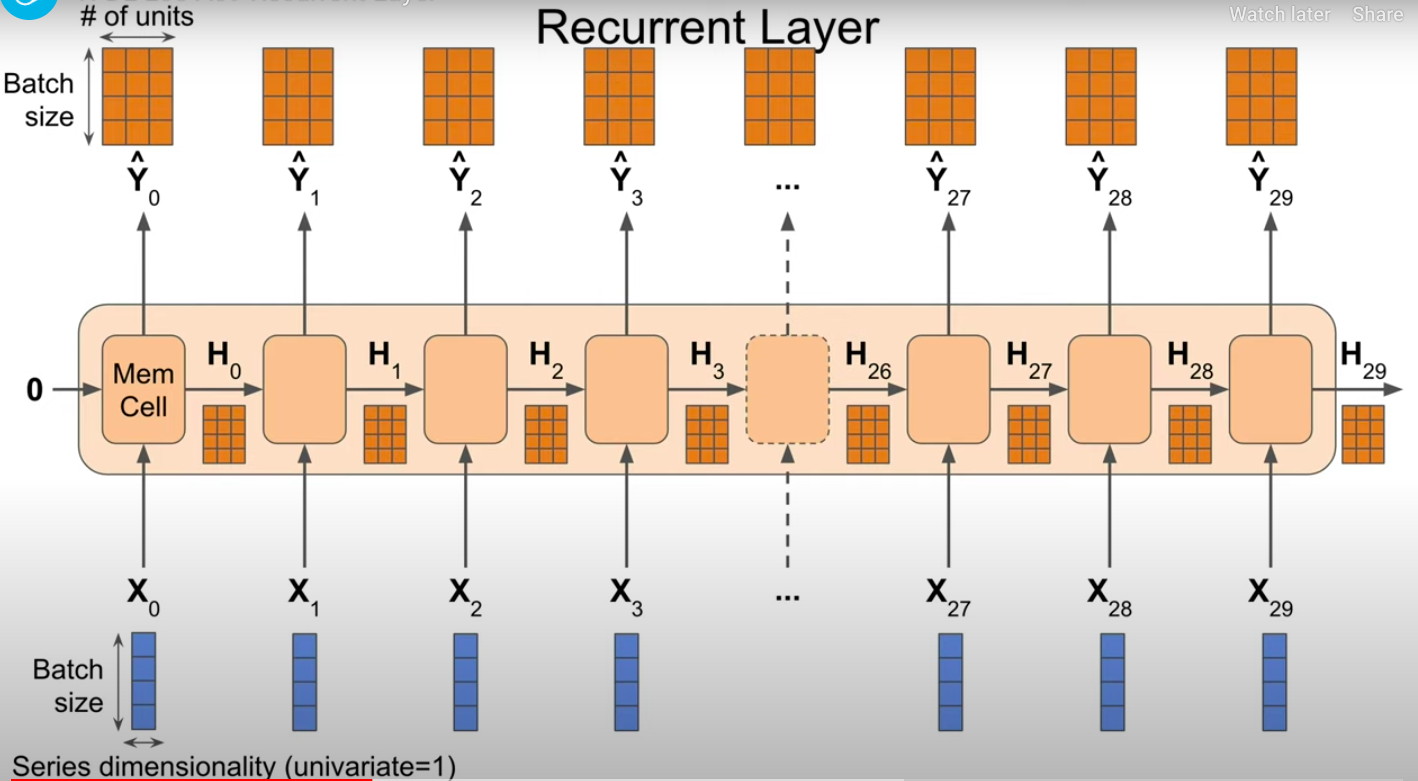

In this example, $H_0$ is just a copy of $\hat{Y_0}$, $H_1$ is just a copy of $\hat{Y_1}$, and so on. At each time step, the memory cell knows what the current input is, and it also knows what the previous output was.

In some cases, you want to input a sequence, but you don't want to output a sequence. You just want to output a single vector for each instance in the batch. This is called a *sequence-to-vector RNN*.

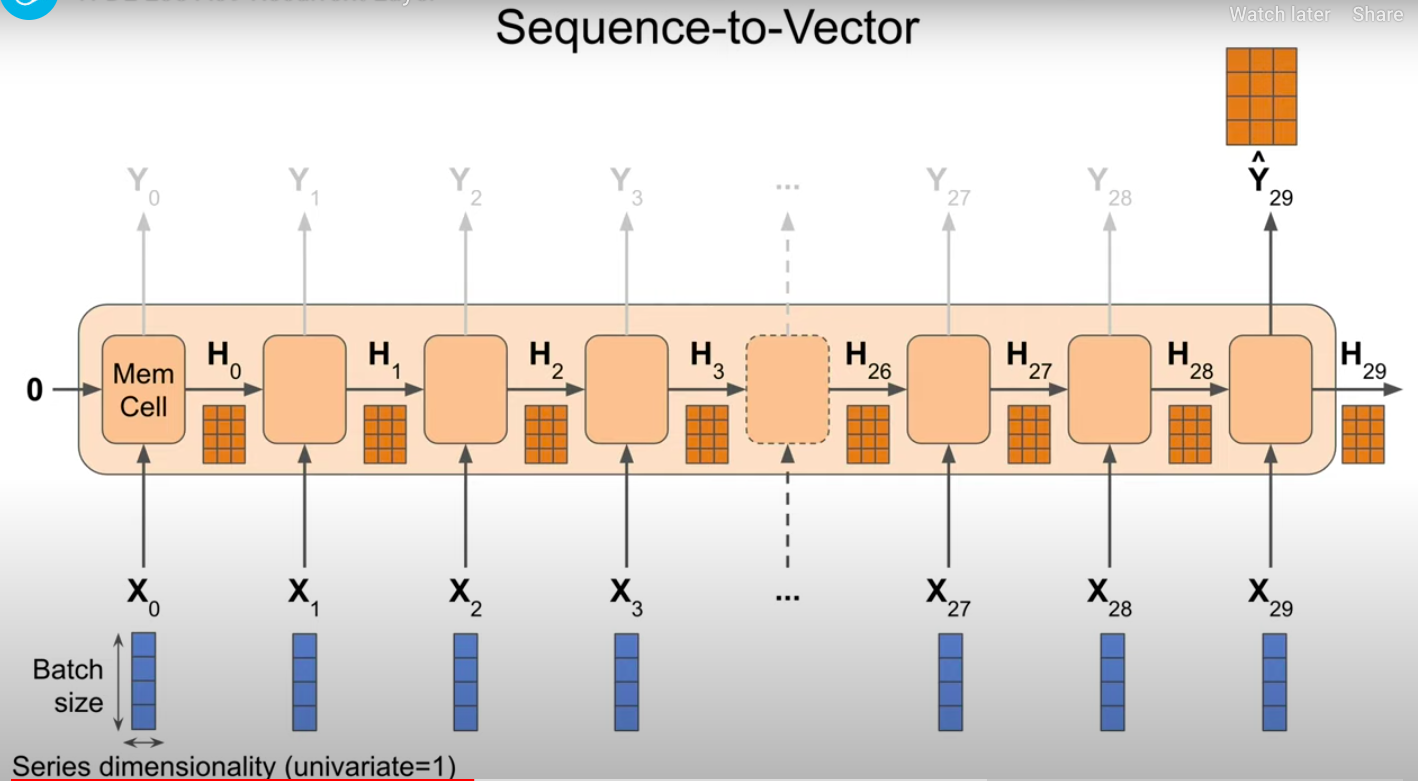

It's quite simple. All you need to do is ignore all the outputs except the last one. In fact, in Keras, this is the default behaviour of all recurrent layers. If you want a recurrent layer to output a sequence, you have to set the argument `return_sequences=True` when creating the layer.

For example, the following RNN contains `2` recurrent layers.

```
model = keras.Sequential([
    keras.layers.SimpleRNN(units=100, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(units=100),
    keras.layers.Dense(units=1)
])
```

**Note:** When using PyTorch's `nn.RNNCell`, you have to create the sequence-to-sequence behavior manually by appending the output at each time step to a list initialized as follows: `output = []`. Then, after running the `for` loop, you need to use `torch.stack` on `output` across `dim=1`. When using PyTorch's `nn.RNN`, this whole thing is done for you. (`nn.RNN` is sequence-to-sequence only. If you want to create a sequence-to-vector layer with `nn.RNN`, you can use slicing to only consider the output of the last time step, and ignore the outputs of the previous time steps.)

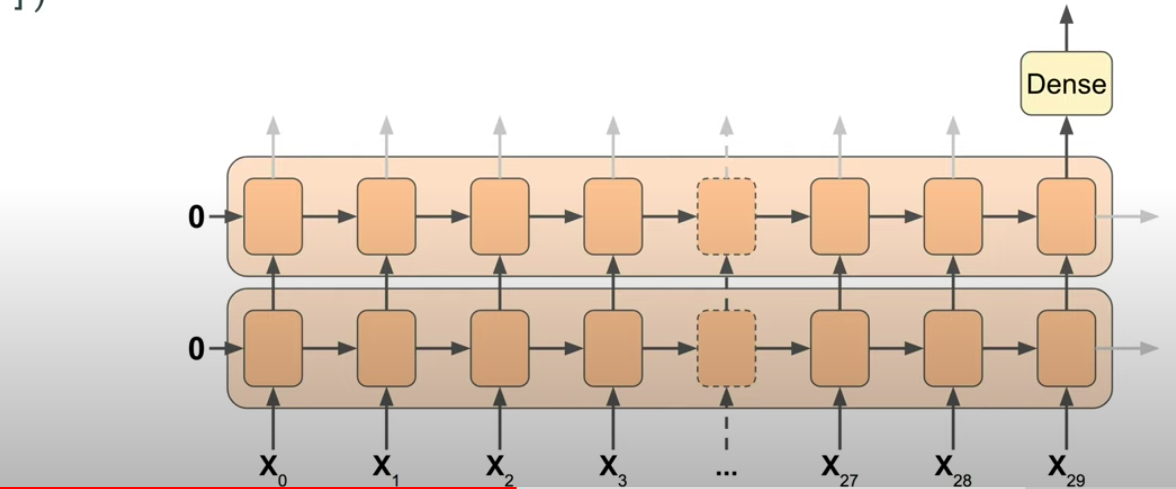

The first layer has `return_sequences=True`, so it outputs a sequence, which is then fed to the second recurrent layer. But this recurrent layer does not have `return_sequences=True`, so it only outputs a vector for the final time step. Since there are `100` units in the second recurrent layer, its outputs at each time step are 100 dimensional. And only the last output is sent to the next layer, which is a dense layer with a single neuron. This final output layer will output a single value for each instance in the batch.

**Note:** The above makes sense when we want to create an RNN to classify sequences, e.g., in "*NLP From Scratch: Classifying Names with a Character-Level RNN*". If we want to (say) generate text, then it would make sense for the second RNN layer to be sequence-to-sequence as well. The dense layer then produces an output for each time step, rather than for the last time step only. Check "*NLP From Scratch: Generating Names with a Character-Level RNN*". Finally, in an encoder-decoder RNN, the encoder's last hidden state (not the output at the last time step - which may be different when using LSTM / GRU cells) is passed to the decoder.

As I mentioned earlier, the input shape of the whole RNN is 3 dimensional: [batch size, # time steps, # dims]. But notice that the `input_shape` argument of the first layer is `[None, 1]`. What does this mean? Well, remember that Keras assumes that the first dimension is the batch size, which can be anything.

**Note:** Recall that we don't need to specify the batch size in `input_shape` (it's implicit). For example, in Lesson 3, we specified `input_shape=(28, 28, 1)` (where `1` was the number of color channels). This is despite the fact that the batch size was `32`, and the input tensors were 4 dimensional (with shape `(32, 28, 28, 1)`).

The second dimension (`None`) refers to the number of time steps. This means that this RNN will handle sequences of any length. This is new. With regular dense layers, you have to specify exactly how many features you will get as input for each instance. But since a recurrent layer just reuses the same memory cell at each time step, it can handle sequences of any length.

The third dimension is `1`, because we're dealing with a univariate time series.

Since, we're using a simple RNN layer, it is based on the `SimpleRNN` cell class, which behaves very much like a dense layer. At each time step, it performs a weighted sum of its inputs (which includes the input for that time step and the state from the previous time step). And then it applies an activation function. That's about it.

Notice that we didn't specify the activation function. That's because it defaults to `'tanh'` (the hyperbolic tangent function). You might wonder why we don't use the `'relu'` activation function. The problem is that RNNs have a tendency to have unstable gradients. The gradients can vanish during training, or they can explode, especially if you're using an activation function such as `'relu'` which is *non-saturating* (i.e., it can grow arbitrarily large). By using `'tanh'` which is *saturating*, we get gradients that are a bit more stable. But we might still get vanishing gradients. So training may be super slow.

Now, if we set `return_sequences=True` in all recurrent layers, then they will all output sequences, and thus the dense layer will get a sequence as an input. **In that case, the way Keras handles this is that it actually applies the same dense layer independently at each time step.**

```
model = keras.Sequential([
    keras.layers.SimpleRNN(units=100, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(units=100, return_sequences=True),
    keras.layers.Dense(units=1)
])
```

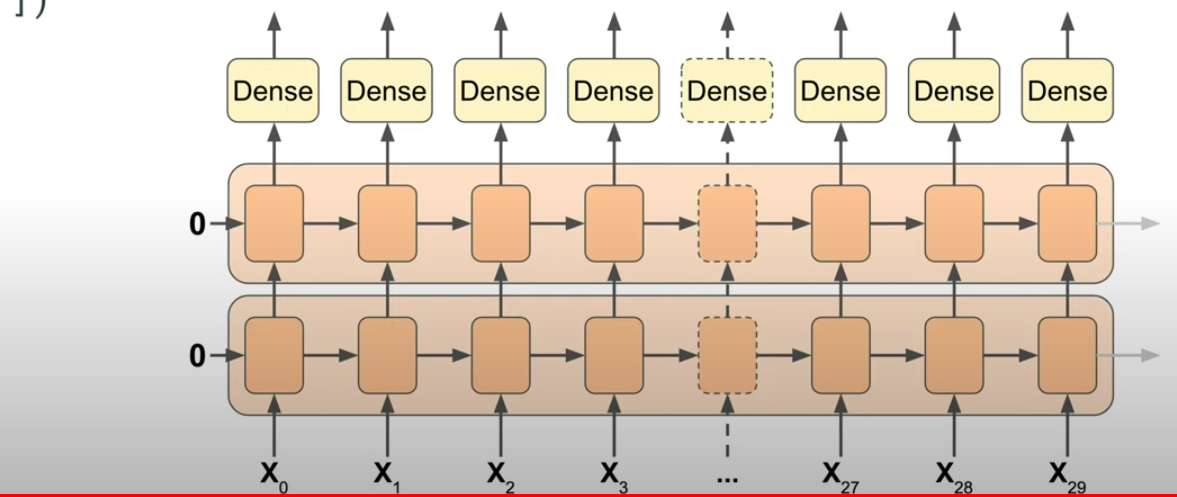

In the above diagram, I represented the dense layer multiple times, but it's important to understand that the **same** dense layer is used independently at each time step. This gives a *sequence-to-sequence* RNN. You feed it a batch of sequences, and it outputs a batch of sequences of the same length. In this case, we used a single unit in the dense layer, so the output sequence will be univarate (just like the input sequence). But **the dimensionality of the output sequence will not always match the dimensionality of the input sequence. It really depends on the task.** (For example, in causal language modeling, each token may be represented by an input embedding vector of length 768. But the number of units of the final linear layer will be equal to the vocab size.)

## XIII. Forecasting with an RNN

We're now ready to train our first RNN to forecast the same time series as earlier. All we need is an RNN that can take in a batch of time windows, and forecast the next value for each window in the batch. (This is a sequence-to-vector RNN.)

We can just use the model we looked at earlier. However, since our dataset was built to return 2 dimensional batches of windows (where the first dimension is the batch size and the second dimension is the number of time steps), we need to add an extra dimension. (Remember that an RNN expects 3 dimensional inputs having shape [batch size, # time steps, # dims].)

We could go ahead and update our `window_dataset` function. But it's not too hard to make the model itself fix the shape of the inputs, using a `Lambda` layer that calls the `tf.expand_dims` function. This will add an extra dimension at the end.


In [5]:
x = np.array([[0, 1, 2, 3], [1, 2, 3, 4]])
x

array([[0, 1, 2, 3],
       [1, 2, 3, 4]])

In [6]:
import tensorflow as tf

tf.expand_dims(x, axis=-1)

<tf.Tensor: shape=(2, 4, 1), dtype=int64, numpy=
array([[[0],
        [1],
        [2],
        [3]],

       [[1],
        [2],
        [3],
        [4]]])>

```
model = keras.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    keras.layers.SimpleRNN(units=100, return_sequences=True),
    keras.layers.SimpleRNN(units=100),
    keras.layers.Dense(units=1),
    keras.layers.Lambda(lambda x: x * 200.0)
])
```

We define the `input_shape` as `[None]`, meaning that the model will support sequences of any length. We also scale the outputs by a factor of `200.0`. This is useful since the time series has values ranging from around 40 to around 160, but the recurrent layers are using the `'tanh'` activation function, which outputs values between `-1` and `1`. So scaling the outputs up by a factor of `200.0` will help training. (**Note:** We haven't scaled the inputs at all. They are fairly large. **By multiplying the outputs by `200.0`, we make it easier for the model to use fairly small weights and yet produce fairly large outputs.** Another way to achieve the same result would be to normalize the inputs. In fact, that would be more common. We can achieve this by using a `Lambda` layer.)

**Note:** `sigmoid_range` might be a better choice in this context (compared to multiplying by `200.0`).

After training this RNN, we get the following forecasts.

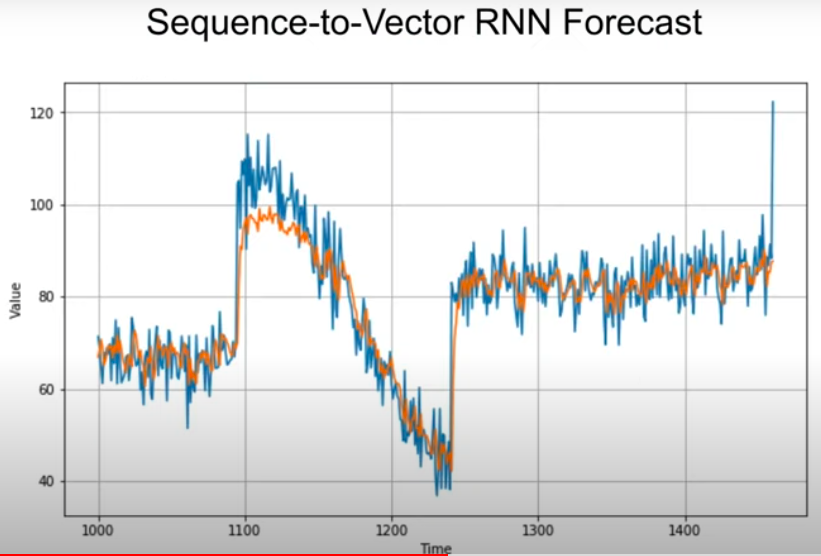

They are not quite as good as the forecasts from our previous models. The MAE is about 5.1. You can try to improve this model by tuning its hyperparameters. For example, there are probably way too many neurons, and perhaps a single recurrent layer would suffice.

However, you will see that training an RNN is actually tricky. If you set the learning rate too high, training is unstable, and the RNN doesn't learn. But if you set the learning rate low enough to avoid the instabilities, training is really slow.

Moreover, during training, the loss jumps up and down unpredictably. If you use early stopping, it may interrupt training too early. Make sure you set the `patience` argument to a large enough value. However, this means that the final model will be long after the best model seen during training. And it may be much worse. So it's probably a good idea to save checkpoints every time the model improves, and rollback to the best model at the end of training. To do this, you can use the `ModelCheckpoint` callback, and set its `save_best_only` argument to `True`.

```
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    'my_checkpoint.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
)

model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping, model_checkpoint])

model = keras.models.load_model('my_checkpoint.h5')
```

At each epoch, this callback will save the model if it has the best validation performance seen so far. At the end of training, we just load the last model saved, and it will be the one with the lowest validation loss.

**Note:** The above approach is equivalent to setting `restore_best_weights` to `True` in the `EarlyStopping` callback.

## XIV. Back-Propagation Through Time (BPTT)

One of the reasons why it's difficult to train an RNN is that it's equivalent to training a fairly deep neural network with one layer per time step.

During training, once the loss has been computed, back-propagation computes the gradients (partial derivatives to be more precise) of the loss w.r.t. every trainable parameter in the neural network. And to do so, it propagates the gradients backwards through the RNN. This means that the gradients flow down the RNN layers, but they also flow backwards through time.

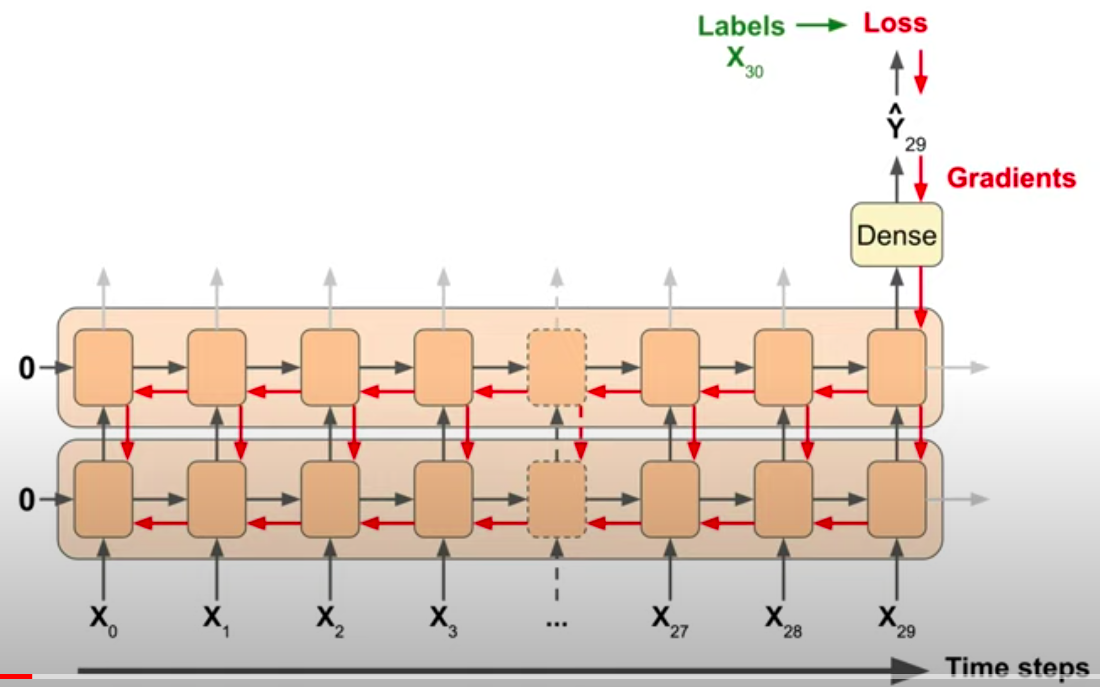

Deep learning libraries like TensorFlow do this by 'unrolling' the RNN through time (as shown above), and treating the resulting network as a regular feed forward network. So the RNN is like a very deep net. The more time steps there are, the deeper it is.

The gradients tend to vanish or explode when going backwards through many layers and many time steps. So training can be quite slow, specially when trying to detect long-term patterns (i.e., over a long time window).

To speed things up, one approach is to train the RNN to make a prediction at each and every time step. Instead of a sequence-to-vector RNN, we now have a sequence-to-sequence RNN.

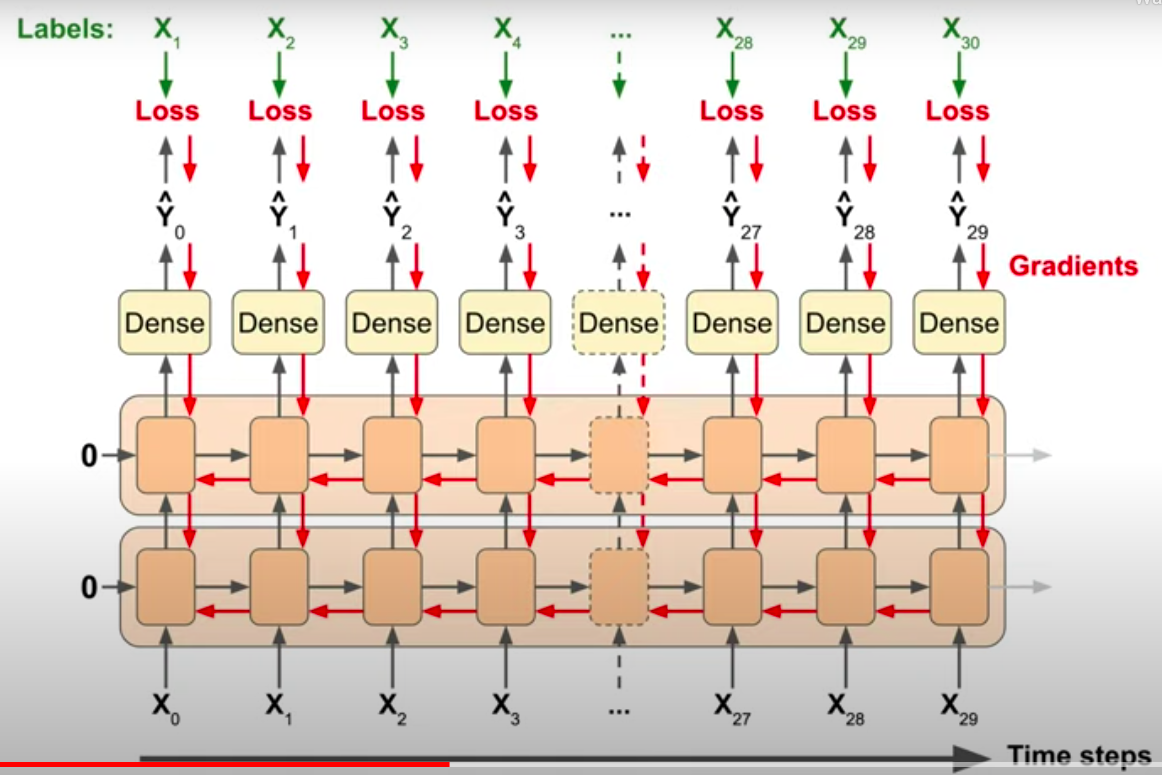

The labels are just equal to the inputs, but shifted one time step into the future. For example, at time step $1$, the RNN gets $X_1$ as input (plus the previous state $H_0$), and it must try to output $X_2$. So instead of looking at the inputs and trying to forecast a single value (in this case $X_{30}$), the RNN tries to forecast the next time step at each and every time step.

The advantage of this approach is that it provides many more gradients for training. **If the forecast is bad at one time step, there will be a strong loss at that time step, and it will back-propagate directly to update the weights at that time step.** This can stabilize and speed up training.

Note that this is just a trick to stablize and speed up training. We don't really care about the outputs (except for the very last time step). After training, we will look only at the very last output (and drop the remaining ones) when we make predictions. **Note:** This means that the loss and the metric are likely to be very different.

To implement this sequence-to-sequence approach, we'll write a new function that will create a dataset. This is just like we did earlier, except that the labels are now sequences (shifted by one time step into the future). Also, we might as well return sequences that have the proper 3 dimensional shape suitable for recurrent layers (so that we don't have to use a `Lambda` layer to reshape them at the beginning of the RNN). For this, we'll call `tf.expand_dims` at the beginning of the function.

```
def seq2seq_window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[1:])) # Notice the change in the 2nd slice.
    ds = ds.shuffle(shuffle_buffer)
    return ds.batch(batch_size).prefetch(1)
```

Next, we'll call this function to create two datasets: one for the training period, and one for the validation period.

```
window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)
```

Then we'll create the RNN model.

```
model = keras.Sequential([
    keras.layers.SimpleRNN(units=100, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(units=100, return_sequences=True),
    keras.layers.Dense(units=1),
    keras.layers.Lambda(lambda x: x * 200.0)
])
```

Since it's a sequence-to-sequence model, we'll make sure that we set `return_sequences` to `True` in every recurrent layer (including the last one).

This model will take windows of univariate time series as input, and it will output windows of the same length (also univariate). Once we train it, the output window should be close to the input, but shifted one time step into the future.

Next, we'll compile and train the model exactly like we did earlier using Huber loss and SGD with momentum optimizer.

```
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    'my_checkpoint.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
)

optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=['mae])

model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping, model_checkpoint])
```

After training, this is what the forecasts will look like.

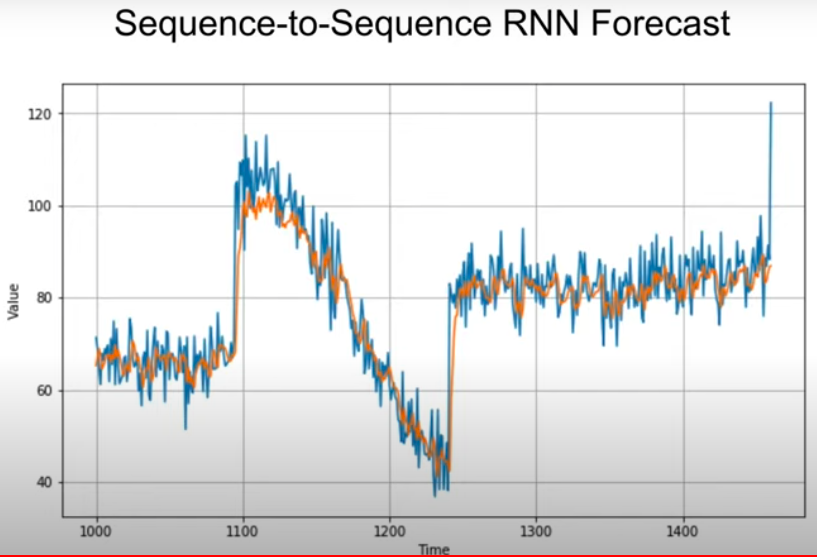

They are much better than using the sequence-to-vector RNN, and the MAE is about 5.0. That's pretty good, but not as good as our linear regression model or the third moving average approach. This is a good lesson to remember. RNNs can be impressive on some time series, especially when there is a lot of training data (e.g., high frequency time series), and when the signal-to-noise ratio is high. But they don't always work well.

## XV. Colab: Forecasting with RNNs

In this notebook, we'll build two types of models: (i) a sequence-to-vector RNN and (ii) a sequence-to-sequence RNN.

### Setup

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [8]:
def plot_series(time, series, format='-', start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    if label is not None:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern; you can change it if you wish."""
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern in each period."""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    return np.random.RandomState(seed).randn(len(time)) * noise_level

def window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

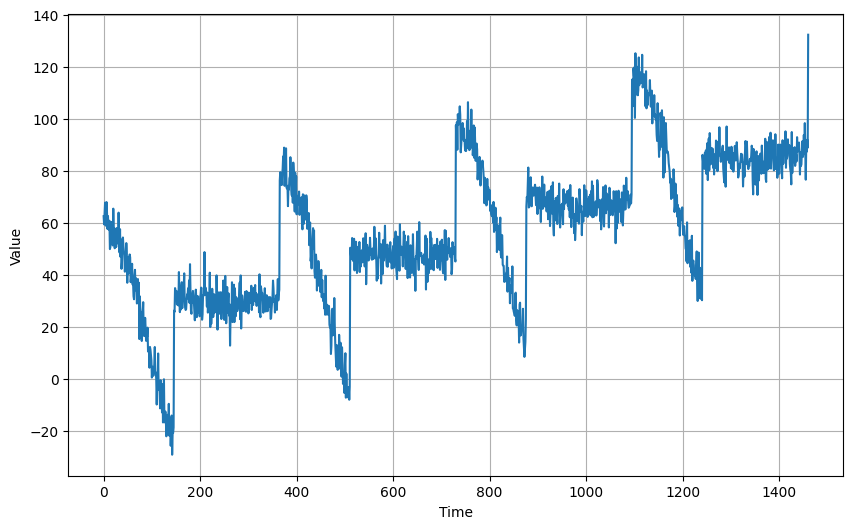

In [9]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 50
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [10]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Sequence-to-Vector RNN

In [11]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [12]:
window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

In [13]:
model = keras.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    keras.layers.SimpleRNN(units=100, return_sequences=True),
    keras.layers.SimpleRNN(units=100),
    keras.layers.Dense(units=1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

In [14]:
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20)
)

In [15]:
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(
    loss=keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae']
)

In [16]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 34ms/step - loss: 397.7693 - mae: 398.2693 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 29ms/step - loss: 356.3056 - mae: 356.8056 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 0s 27ms/step - loss: 284.5676 - mae: 285.0676 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 0s 27ms/step - loss: 187.1556 - mae: 187.6556 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 0s 26ms/step - loss: 66.2514 - mae: 66.7507 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 0s 28ms/step - loss: 43.5537 - mae: 44.0530 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 0s 27ms/step - loss: 32.8844 - mae: 33.3816 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 0s 27ms/step - loss: 24.8737 - mae: 25.3659 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 0s 29ms/step - loss: 20.3228 - mae: 20.8158 -

Pretty fast without a GPU!

(1e-07, 0.0001, 0.0, 30.0)

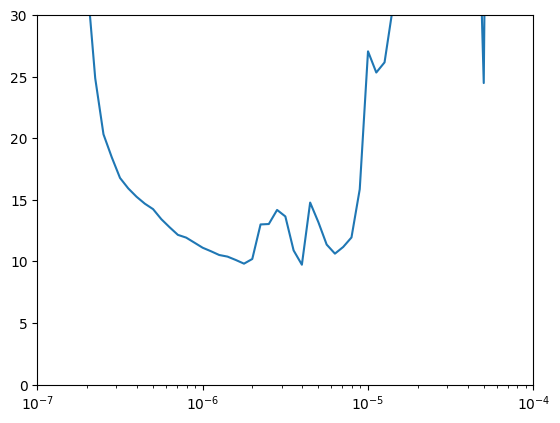

In [17]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-7, 1e-4, 0, 30]);

Let's go with a learning rate of `1e-6`.

In [18]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [19]:
window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

In [20]:
model = keras.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    keras.layers.SimpleRNN(units=100, return_sequences=True),
    keras.layers.SimpleRNN(units=100),
    keras.layers.Dense(units=1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

In [21]:
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    'my_checkpoint.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
)

In [22]:
optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(
    loss=keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae']
)

In [23]:
model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
      7/Unknown - 2s 31ms/step - loss: 15.8283 - mae: 16.3172
Epoch 1: val_loss improved from inf to 20.47936, saving model to my_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 3s 165ms/step - loss: 15.3876 - mae: 15.8761 - val_loss: 20.4794 - val_mae: 20.9773
Epoch 2/500
7/8 [=========================>....] - ETA: 0s - loss: 14.0912 - mae: 14.5799
Epoch 2: val_loss improved from 20.47936 to 16.62611, saving model to my_checkpoint.h5
8/8 [==============================] - 0s 45ms/step - loss: 14.3509 - mae: 14.8394 - val_loss: 16.6261 - val_mae: 17.1221
Epoch 3/500
7/8 [=========================>....] - ETA: 0s - loss: 14.2878 - mae: 14.7784
Epoch 3: val_loss improved from 16.62611 to 14.39397, saving model to my_checkpoint.h5
8/8 [==============================] - 0s 50ms/step - loss: 14.0661 - mae: 14.5562 - val_loss: 14.3940 - val_mae: 14.8890
Epoch 4/500
7/8 [=========================>....] - ETA: 0s - loss: 13.0163 - mae: 13.5024
Epoch 4: val_loss improved from 14.39397 to 12.42219, saving model to my_checkpoint.h5
8/8 [==============================] - 1s 57ms/step - loss: 12.9650 - mae: 13.4514 - val_loss: 12.4222

In [24]:
model = keras.models.load_model('my_checkpoint.h5')

In [28]:
# Exploratory:
model_forecast(model, series[split_time - window_size:-1], window_size).shape

15/15 [==============================] - 0s 14ms/step


(461, 1)

In [27]:
rnn_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

15/15 [==============================] - 0s 8ms/step


**Note:** The `[:, 0]` slicing works because it's a sequence-to-vector RNN.

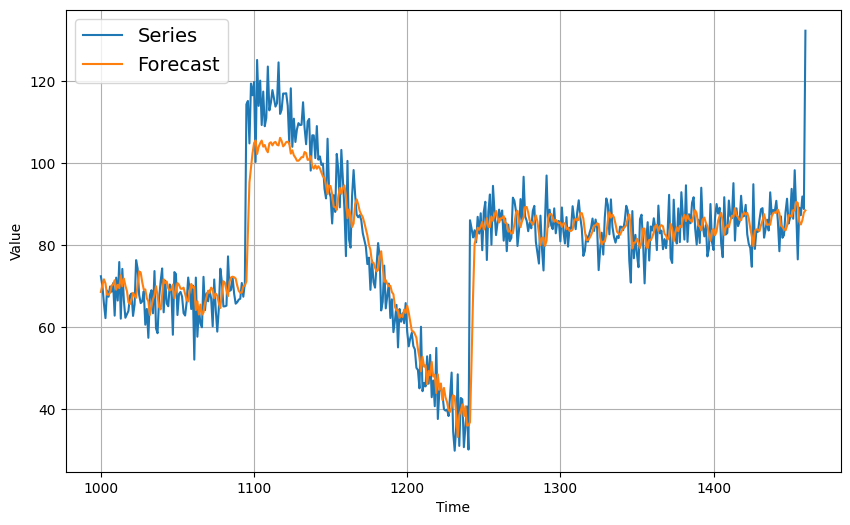

In [29]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label='Series')
plot_series(time_valid, rnn_forecast, label='Forecast')
plt.show()

The forecasts are not fantastic. Our fairly simple RNN, in this case, is not capable of capturing these long-term patterns which evolve over hundreds of time steps. It's doing a bad job especially when there is a lot of movement in the time series.

In [30]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.451965

The MAE is not really competitive with the previous models we've trained. That said, a simple model like this could work with other time series datasets, and it could also work if we had preprocessed our time series a little bit more, e.g., normalizing the inputs, removing the trend & seasonality, etc.

### Sequence-to-Sequence RNN

In [31]:
def seq2seq_window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    ds = ds.shuffle(shuffle_buffer)
    return ds.batch(batch_size).prefetch(1)

In [32]:
tf.range(10)

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>

**Note:** Don't confuse `tf.range` with `tf.data.Dataset.range`, which returns a dataset of tensors.

In [33]:
for x_batch, y_batch in seq2seq_window_dataset(tf.range(10), window_size=3, batch_size=2):
    print('x =', x_batch.numpy())
    print('y =', y_batch.numpy())

x = [[[4]
  [5]
  [6]]

 [[1]
  [2]
  [3]]]
y = [[[5]
  [6]
  [7]]

 [[2]
  [3]
  [4]]]
x = [[[0]
  [1]
  [2]]

 [[5]
  [6]
  [7]]]
y = [[[1]
  [2]
  [3]]

 [[6]
  [7]
  [8]]]
x = [[[2]
  [3]
  [4]]

 [[6]
  [7]
  [8]]]
y = [[[3]
  [4]
  [5]]

 [[7]
  [8]
  [9]]]
x = [[[3]
  [4]
  [5]]]
y = [[[4]
  [5]
  [6]]]


In [34]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [35]:
window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

In [36]:
model = keras.Sequential([
    keras.layers.SimpleRNN(units=100, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(units=100, return_sequences=True),
    keras.layers.Dense(units=1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

In [37]:
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30)
)

In [38]:
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(
    loss=keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae']
)

In [39]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 39ms/step - loss: 161.9630 - mae: 162.4628 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 36ms/step - loss: 121.0627 - mae: 121.5626 - lr: 1.0798e-07
Epoch 3/100
8/8 [==============================] - 0s 36ms/step - loss: 60.9856 - mae: 61.4842 - lr: 1.1659e-07
Epoch 4/100
8/8 [==============================] - 0s 35ms/step - loss: 39.0428 - mae: 39.5396 - lr: 1.2589e-07
Epoch 5/100
8/8 [==============================] - 0s 39ms/step - loss: 37.8390 - mae: 38.3357 - lr: 1.3594e-07
Epoch 6/100
8/8 [==============================] - 0s 36ms/step - loss: 28.2593 - mae: 28.7544 - lr: 1.4678e-07
Epoch 7/100
8/8 [==============================] - 0s 35ms/step - loss: 23.5839 - mae: 24.0760 - lr: 1.5849e-07
Epoch 8/100
8/8 [==============================] - 0s 35ms/step - loss: 20.0504 - mae: 20.5395 - lr: 1.7113e-07
Epoch 9/100
8/8 [==============================] - 0s 39ms/step - loss: 19.0177 - mae: 19.5057 - lr:

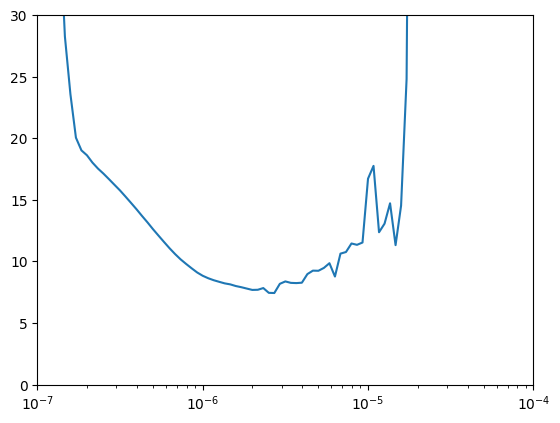

In [40]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-7, 1e-4, 0, 30]);

Let's go with a learning rate of `1e-6`.

In [41]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [42]:
window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)

In [43]:
model = keras.Sequential([
    keras.layers.SimpleRNN(units=100, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(units=100, return_sequences=True),
    keras.layers.Dense(units=1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

In [44]:
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    'my_checkpoint.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
)

In [45]:
optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(
    loss=keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae']
)

In [46]:
model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
      7/Unknown - 2s 29ms/step - loss: 202.6678 - mae: 203.1677
Epoch 1: val_loss improved from inf to 29.27758, saving model to my_checkpoint.h5
8/8 [==============================] - 2s 99ms/step - loss: 190.8774 - mae: 191.3771 - val_loss: 29.2776 - val_mae: 29.7722
Epoch 2/500
7/8 [=========================>....] - ETA: 0s - loss: 97.9238 - mae: 98.4232  
Epoch 2: val_loss improved from 29.27758 to 21.99570, saving model to my_checkpoint.h5
8/8 [==============================] - 0s 49ms/step - loss: 94.7160 - mae: 95.2153 - val_loss: 21.9957 - val_mae: 22.4912
Epoch 3/500
7/8 [=========================>....] - ETA: 0s - loss: 44.4716 - mae: 44.9695
Epoch 3: val_loss did not improve from 21.99570
8/8 [==============================] - 0s 44ms/step - loss: 43.7243 - mae: 44.2222 - val_loss: 36.1234 - val_mae: 36.6230
Epoch 4/500
8/8 [==============================] - ETA: 0s - loss: 30.1693 - mae: 30.6668
Epoch 4: val_loss improved from 21.99570 to 19.44099, saving model 

The early stopping callback didn't stop training (it went all the way to `500` epochs). This means that the model was still making progress on the validation loss. Presumably, if we increase the number of epochs to a higher value, the model will continue to improve.

In [48]:
model = keras.models.load_model('my_checkpoint.h5')

Reproduced for convenience:

```
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast
```

In [49]:
series_2d = tf.expand_dims(series, axis=-1)
series_2d

<tf.Tensor: shape=(1461, 1), dtype=float64, numpy=
array([[ 62.48357077],
       [ 59.35127045],
       [ 63.30881273],
       ...,
       [ 91.87937625],
       [ 88.82580493],
       [132.30772008]])>

We can do the same thing using NumPy.

In [50]:
series_2d = series[..., np.newaxis]
series_2d

array([[ 62.48357077],
       [ 59.35127045],
       [ 63.30881273],
       ...,
       [ 91.87937625],
       [ 88.82580493],
       [132.30772008]])

Either one of the TensorFlow / NumPy versions can be passed to `model_forecast` (since `tf.data.Dataset.from_tensor_slices` accepts TensorFlow tensors as well as NumPy arrays).

Creating `series_2d` allows us to reuse the `model_forecast` function.

In [51]:
# Exploratory:
model_forecast(model, series_2d[split_time - window_size:-1], window_size).shape

15/15 [==============================] - 0s 10ms/step


(461, 30, 1)

In [52]:
seq2seq_rnn_forecast = model_forecast(model, series_2d[split_time - window_size:-1], window_size)[:, -1, 0]
seq2seq_rnn_forecast.shape

15/15 [==============================] - 0s 11ms/step


(461,)

**Note:** The second value in the slice is `-1` because we only care about the last time step's prediction (for each window).

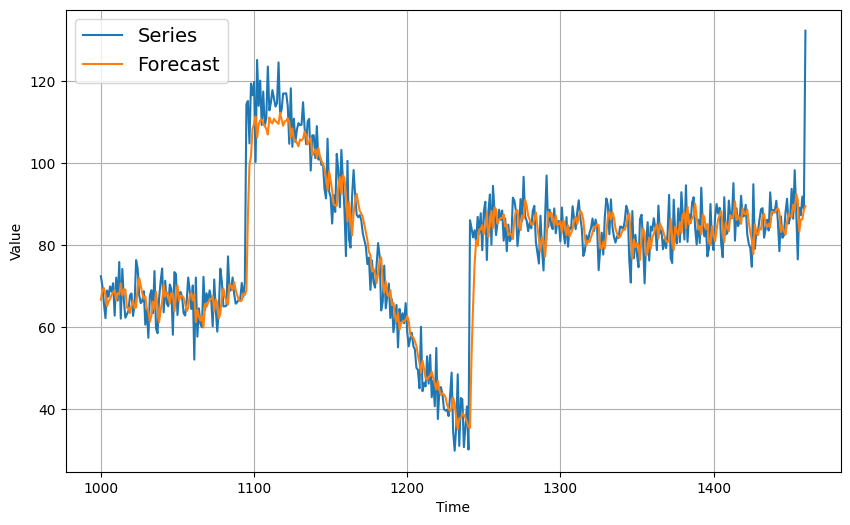

In [53]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label='Series')
plot_series(time_valid, seq2seq_rnn_forecast, label='Forecast')
plt.show()

The forecasts are a bit better than before, but still not great.

In [54]:
keras.metrics.mean_absolute_error(x_valid, seq2seq_rnn_forecast).numpy()

5.1412015

The MAE is about 5.0. This is better than the sequence-to-vector model and the dense model, but it's still not better than the linear regression model and the last moving average approach.

## XVI. Stateless and Stateful RNNs

The way we've trained the RNNs so far was to show them short sequences of just `30` time steps. There is no way they can learn patterns longer than that.

If we want them to learn longer patterns, we have three options:

1. Use larger windows. However, simple RNNs like the ones we've used aren't capable of learning very long-term patterns. They can at most learn a few dozen time steps.
2. Use LSTM memory cells, which are capable of learning long-term patterns. (More on this later...)
3. Use *stateful RNNs*. This requires us to train the RNNs completely differently. Let's see how.

**Note:** It's possible to combine the above three options.

Until now, we've trained our RNNs using batches of windows sampled anywhere within the time series. In the following diagram, the batches are composed of three windows (the batch size is `3`).

![](https://drive.google.com/uc?export=view&id=1iHVtQY640XE-BWgAtqvDGEU89OUC7MD2)

The next batch is also composed of windows sampled anywhere within the time series.

![](https://drive.google.com/uc?export=view&id=1OeE0ywFdehwOTV4JbU51gdVvWIKqelaj)

In fact, these windows can overlap sometimes (like shown above).

And again, the next batch is another set of windows from the time series.

![](https://drive.google.com/uc?export=view&id=1ub40bKFZSqGUHlQKcsQ07p052vSuL2Rj)

And so on...

Now, for each batch, the RNN will make its predictions. But to do so, it will use an initial state equal to $0$ (a matrix comprising of zeros).

![](https://drive.google.com/uc?export=view&id=1nPCEgflUo2atdTXxl2QviNRFh0EXVLDu)

Internally, it will update the state at each time step, until it has made its predictions. During training, there will be a round of back-propagation. And after this, the RNN will drop the final state. This is why we call this type of RNN a *stateless RNN*. (It's not really stateless, since the RNN does use an internal state in making predictions. And it keeps updating this internal state until it has made its predictions. After it has made its predictions and done a backpropagation step, it drops the final state. At each training iteration, it starts with a fresh $0$ state.)

**Note:** Don't confuse the memory's cell's weights with its state. The state matrix is a batch of **activations** of the memory cell at each time step.

Stateless RNNs are nice and simple to use. But they cannot learn patterns longer than the length of the window.

Now, let's look at how stateful RNNs work.

The batches are not sampled randomly any more. The first batch is composed of a **single** window at the very beginning of the time series.

![](https://drive.google.com/uc?export=view&id=1dCRD0wSzkFCBO2mZ182sDCsTCG9nfwk3)

There is no previous state, so we start with a $0$ state. The RNN makes its predictions (gradually updating the state matrix). Then there is a round of back-propagation. But this time, the final state is not dropped. It is preserved by the RNN for the next training batch.

The next batch is composed of a single window located immediately after the previous one.

![](https://drive.google.com/uc?export=view&id=1DJfwFBi_Cq_woWxnXBlWH6G5z_gZGb0W)

Instead of starting with a $0$ state matrix, we now start with the final state matrix of the previous training iteration. The RNN makes its predictions (updating the state matrix at each time step). Then there is a round of back-propagation on this batch. And again, the final state matrix is preserved for the next training iteration.

The process continues like this over the whole time series.

![](https://drive.google.com/uc?export=view&id=1wzcYUu4_Rwcm7eaaJ2UmdWE983sZVp7P)

Once we reach the end of the time series, we get a final state matrix. But at this point, we can reset the state and start over at the beginning of the time series.

So, at each epoch, we feed the network with consective windows at each training iteration. And at the end of the epoch, we reset the state matrix to $0$.

![](https://drive.google.com/uc?export=view&id=1OshkCToY3_Jj_Hb36g4thAW7PW3hhXht)

**Note:** In the above example, the number of training instances is `8`. So `steps_per_epoch` (implicit) is equal to `8` (since the batch size is `1`).

The benefit of this approach is that the RNN gets a meaningful state matrix at the beginning of each training iteration. After training for several epochs, this will allow the RNN to learn long-term patterns despite only running back-propagation over a single window at a time.

The downsides, however, are that the dataset must be prepared very differently (it's a bit trickier to implement and it's easy to make mistakes), and since we only use a single window at each training iteration, training can be very slow. Moreover, since consecutive training batches are very correlated, back-propagation may not work as well. Because of all these downsides, stateful RNNs are much less used than stateless RNNs.

But on some tasks, they can lead to better performance.

**Note:** Training is not necessarily slower, because there are fewer windows (since they are non-overlapping). So there are fewer instances in each epoch.

## XVII. Implementing a Stateful RNN

Let's see how to implement a stateful RNN.

First, we need yet another function to create the dataset.

```
def sequential_window_dataset(series, window_size):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True) # NOTICE THE CHANGE IN THE SECOND ARGUMENT.
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.map(lambda w:(w[:-1], w[1:])) # SEQUENCE-TO-SEQUENCE.
  return ds.batch(1).prefetch(1)
```

This function is very similar to the previous one, except:

1.  We use `shift=window_size` (instead of `shift=1`) when calling the `window` method. With this specification, each window will immediately follow the previous window.
2. We do not shuffle the windows any more. They need to be consecutive.
3. We use batches containing a single window. (It's actually possible to implement a stateful RNN using batches containing more than one window. But it's quite tricky to implement. So most people don't bother, and we won't discuss this here.)

Next, we'll create the datasets for the training and validation periods.

```
window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(series, window_size) # NOTICE THAT WE PASS `series`, NOT `x_valid`.
```

---

**Note:**

1. With this specification, the state carries over from the training period to the validation period.
2. The disadvantage is that we'll see overly optimistic validation metrics during training, i.e., metrics computed on the entire series. The metric computed after obtaining our forecasts (i.e., only on the validation period) will be worse. Moreover, the `EarlyStopping` callback may not kick in.
3. The advantage is that during inference, we are going to obtain the validation period forecasts by first obtaining the forecasts on the entire time series (instead of using windows for forecasting), and then extracting the validation period slice. (This is possible because an RNN can take sequences of ANY length as input.) So this 'carry over' of the state from the training period to the validation period will be applied consistently (i.e., during both training and inference).

An alternative specification is:

```
valid_set = sequential_window_dataset(x_valid, window_size)
```

With this specification, the state DOES NOT carry over from the training period to the validation period, i.e., the validation period starts with a $0$ state.

---

Now, we'll create the stateful RNN. To do this with Keras, we just need to set `stateful=True` in every recurrent layer. We must also specify the `batch_input_shape` (rather than the `input_shape`) in the first layer. This is the same as the `input_shape`, except that we also specify the batch size (which is `1` in this implementation). This is needed because Keras has to know how many state vectors (i.e., the number of rows of the state matrix) it will have to preserve between the end of one training iteration and the start of the next one. This also means that this RNN will only be usable with batches of size `1` (both during training and after training). (This is another severe limitation of stateful RNNs.)

```
model = keras.Sequential([
  keras.layers.SimpleRNN(units=100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(units=100, return_sequences=True, stateful=True),
  keras.layers.Dense(units=1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
```

Next, we'll compile and train the model. In this example, we use the `EarlyStopping` and `ModelCheckpoint` callbacks.

```
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
  'my_checkpoint.h5',
  monitor='val_loss',
  mode='min',
  save_best_only=True,
  save_freq='epoch',
  verbose=1
)

optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

model.compile(
  loss=keras.losses.Huber(),
  optimizer=optimizer,
  metrics=['mae']
)

model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping, model_checkpoint])

model = keras.models.load_model('my_checkpoint.h5')
```

But wait! We aren't finished yet.

We need to reset the state at the beginning of each and every epoch. The `fit` method does not do this for us. This is because it does not know when a window has reached the end of the time series.

The simplest way to implement this is to define a custom callback. We just need to create a sub-class of the `keras.callbacks.Callback` class, and override the `on_epoch_begin` method, making it call `self.model.reset_states`.

Then we'll create an instance of this callback class, and pass it to the `fit` method. Now the RNN state will be reset before each epoch.

```
class ResetStatesCallback(keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs=None):
    self.model.reset_states()

reset_states = ResetStatesCallback()

model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping, model_checkpoint, reset_states])
```

![](https://drive.google.com/uc?export=view&id=1fz73tYmoeIvsXHs7jb6kOBA1v9EYCB8L)

After training this model, we get an MAE of about 6, which is worse than the previous RNN models. Unfortunately, the stateful RNN is unable to improve our metrics.

## XVIII. Colab: Forecasting with Stateful RNNs



In [ ]:
def sequential_window_dataset(series, window_size):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(1).prefetch(1)

In [ ]:
for x_batch, y_batch in sequential_window_dataset(tf.range(10), window_size=3):
  print('x =', x_batch.numpy())
  print('y =', y_batch.numpy())

x = [[[0]
  [1]
  [2]]]
y = [[[1]
  [2]
  [3]]]
x = [[[3]
  [4]
  [5]]]
y = [[[4]
  [5]
  [6]]]
x = [[[6]
  [7]
  [8]]]
y = [[[7]
  [8]
  [9]]]


Notice that the second batch starts immediately after the first batch, and the third batch starts immediately after the second batch.

In [ ]:
class ResetStatesCallback(keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs=None):
    self.model.reset_states()

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

In [ ]:
model = keras.Sequential([
  keras.layers.SimpleRNN(units=100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(units=100, return_sequences=True, stateful=True),
  keras.layers.Dense(units=1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

In [ ]:
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30)
)
reset_states = ResetStatesCallback()

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

model.compile(
    loss=keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae']
)

In [ ]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 2s 9ms/step - loss: 114.6324 - mae: 115.1324
Epoch 2/100
33/33 [==============================] - 0s 7ms/step - loss: 84.3390 - mae: 84.8387
Epoch 3/100
33/33 [==============================] - 0s 7ms/step - loss: 52.4353 - mae: 52.9342
Epoch 4/100
33/33 [==============================] - 0s 8ms/step - loss: 33.0745 - mae: 33.5700
Epoch 5/100
33/33 [==============================] - 0s 7ms/step - loss: 28.6276 - mae: 29.1234
Epoch 6/100
33/33 [==============================] - 0s 7ms/step - loss: 27.3962 - mae: 27.8839
Epoch 7/100
33/33 [==============================] - 0s 8ms/step - loss: 26.1635 - mae: 26.6571
Epoch 8/100
33/33 [==============================] - 0s 8ms/step - loss: 24.9991 - mae: 25.4921
Epoch 9/100
33/33 [==============================] - 0s 7ms/step - loss: 24.0902 - mae: 24.5844
Epoch 10/100
33/33 [==============================] - 0s 7ms/step - loss: 23.3285 - mae: 23.8245
Epoch 11/100
33/33 [=================

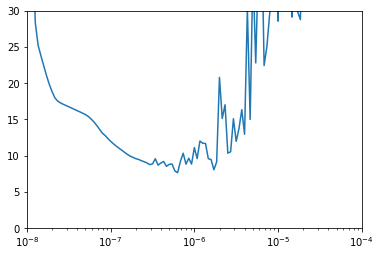

In [ ]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30]);

Let's go with a learning rate of `1e-7`.

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(series, window_size)

In [ ]:
model = keras.Sequential([
  keras.layers.SimpleRNN(units=100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(units=100, return_sequences=True, stateful=True),
  keras.layers.Dense(units=1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    'my_checkpoint.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
)
reset_states = ResetStatesCallback()

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

model.compile(
    loss=keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae']
)

In [ ]:
model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 2s 29ms/step - loss: 88.1553 - mae: 88.6550 - val_loss: 23.5072 - val_mae: 24.0013

Epoch 00001: val_loss improved from inf to 23.50720, saving model to my_checkpoint.h5
Epoch 2/500
33/33 [==============================] - 0s 13ms/step - loss: 27.0857 - mae: 27.5774 - val_loss: 15.7200 - val_mae: 16.2120

Epoch 00002: val_loss improved from 23.50720 to 15.72002, saving model to my_checkpoint.h5
Epoch 3/500
33/33 [==============================] - 0s 13ms/step - loss: 23.2820 - mae: 23.7751 - val_loss: 15.0901 - val_mae: 15.5823

Epoch 00003: val_loss improved from 15.72002 to 15.09010, saving model to my_checkpoint.h5
Epoch 4/500
33/33 [==============================] - 0s 13ms/step - loss: 21.7339 - mae: 22.2234 - val_loss: 13.9703 - val_mae: 14.4611

Epoch 00004: val_loss improved from 15.09010 to 13.97031, saving model to my_checkpoint.h5
Epoch 5/500
33/33 [==============================] - 0s 12ms/step - loss: 21.0822 - mae: 21.5

**Note:** Compared to a stateless RNN, a stateful RNN has fewer windows (since they are non-overlapping). So there are fewer instances in each epoch. Hence, a stateful RNN may require more than `500` epochs to train.

In [ ]:
model = keras.models.load_model('my_checkpoint.h5')

In [ ]:
model.reset_states()

**Note:** We need to reset the state matrix before obtaining our forecasts. This is ensure that the model doesn't have any state left over from training.

In [ ]:
series_3d = series[np.newaxis, :, np.newaxis]

series_3d

array([[[ 62.48357077],
        [ 59.35127045],
        [ 63.30881273],
        ...,
        [ 91.87937625],
        [ 88.82580493],
        [132.30772008]]])

In [ ]:
series_3d.shape

(1, 1461, 1)

We shall treat the entire series as a single instance with `1461` time steps. Since, the RNN is sequence-to-sequence, the prediction will have the same shape.

In [ ]:
model.predict(series_3d).shape

(1, 1461, 1)

In [ ]:
stateful_rnn_forecast = model.predict(series_3d)[0, split_time - 1:-1, 0]

stateful_rnn_forecast.shape

(461,)

**Note:** The second axis slice starts at `split_time - 1` because we aren't using windows to obtain our forecasts. Instead, we are obtaining the forecasts on the entire time series, and then extracting the validation period slice. (This is possible because an RNN can take sequences of ANY length as input.) This 'carries over' the state from the training period to the validation period.

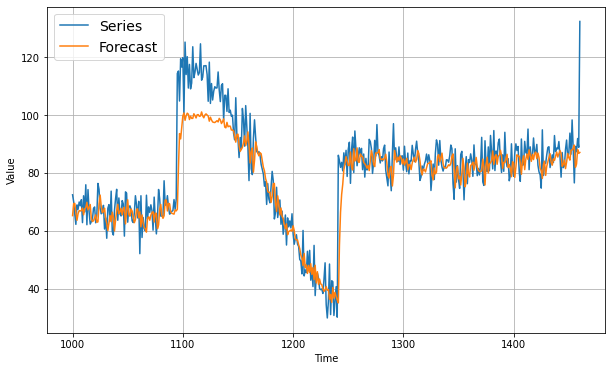

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label='Series')
plot_series(time_valid, stateful_rnn_forecast, label='Forecast')
plt.show()

In [ ]:
keras.metrics.mean_absolute_error(x_valid, stateful_rnn_forecast).numpy()

5.9859004

## XIX. LSTM Cells

Let's look at another tool to make RNNs learn long-term patterns - LSTM (Long Short Term Memory) cells. This is what it looks like:

![](https://drive.google.com/uc?export=view&id=19dUOGtjCCA1MdO9NO4Md6fJ1bNOlWXQ_)

It's much more complex than the simple RNN cells we have been using up until now. But the extra complexity is worth it. It has a much longer memory than simple RNN cells.

You can see that part of the cell is just a good old simple RNN cell (a dense layer with a `'tanh'` activation function), which takes as input $X_t$ and $H_{t - 1}$. This is nothing new.

![](https://drive.google.com/uc?export=view&id=13tDdC7GJnZDQp2g5wLqaUuOkdsPARQz8)

All the other extra components give this cell a long-term memory (or rather a longer short-term memory). An LSTM cell can detect patterns longer than a hundred time steps, but it will still struggle with patterns of several hundred time steps. Let's see how it works.

First, it has a short-term state vector that gets propagated from one time step to the next, just like in the case of the simple RNN cell, but through a different mechanism (as we shall see).

![](https://drive.google.com/uc?export=view&id=1cojv3CklbwB5AagJdchAwX1CwsNlHOWt)

But it also has a second state vector (the long-term state vector).

![](https://drive.google.com/uc?export=view&id=1r4XVG3gCX-Xg4j-7KB4Wc8sih9xUtEy5)

Notice that it goes through the cell with just two simple operations at each time step - a multiplication and then an addition. That's it. Both are element-wise operations, i.e., they apply to each element in the state vector independently from the others. Because it goes through the cell with few computations, the gradients can flow nicely through the cell without vanishing or exploding. This is what gives this cell a longer term memory, and it's really the key idea.

The part of the cell highlighted in the following diagram is called the *forget gate*.

![](https://drive.google.com/uc?export=view&id=11jBAGYCCw62ExBv9V2ZDY4nol4CRK112)

It's just a dense layer with a sigmoid activation function. So it outputs values that are either 0 or 1 (by applying a probability threshold). It has the same inputs as the simple RNN cell ($X_t$ and $H_{t - 1}$). Its output dimension is the same as the long-term state vector ($C_{t - 1}$). So both can be multiplied element-wise. If the forget gate outputs 1, then the corresponding element in the long-term state vector will be multiplied by 1. So it will be unchanged. However, if the forget gate outputs 0, then the corresponding element in the long-term state vector will be multiplied by 0, which will erase it. This is why it's called a forget gate. During training, it will gradually learn when to erase part of the long-term memory. For example, if the long-term memory holds the information that there is a strong upward trend, and the forget gate sees a severe drop in the input values at the current time step, then it will probably learn to erase that part of the long-term memory (since the upward trend is over). In short, the forget gate learns when to forget things and when to preserve them.

The part of the cell highlighted in the following diagram is called the *input gate*.

![](https://drive.google.com/uc?export=view&id=1gekCb_MYnAJfF31hqC-H-QmYLnhauJhe)

It learns when it should store information in the long-term memory. Notice that it has the same inputs as the simple RNN cell and the forget gate. Just like the forget gate, it uses the sigmoid activation function. So it will output values which are either 0 or 1. If it outputs 1, then the corresponding element in the simple RNN cell's output will be multiplied by 1 (which will leave it unchanged), and the result will be added to the long-term memory. Conversely, if the input gate outputs 0, then the corresponding element in the simple RNN cell's output will not be added to the long-term memory. In short, the input gate decides when it's time to remember something. For example, when it detects a strong upward trend which wasn't there before, it might want to add this information to the long-term state vector.

The part of the cell highlighted in the following diagram is called the *output gate*.

![](https://drive.google.com/uc?export=view&id=1zXeVtGjvwd_nWPMn3W-Pv23-IlpdAiT3)

It learns which part of the long-term state vector it should output at each time step. Once again, it outputs values that are either 0 or 1, and these values are multiplied element-wise with the corresponding elements of the of the long-term state vector (after it goes through a `'tanh'` activation function). And this gives the output for the current time step ($\hat{Y_t}$). Note that the short-term state vector ($H_t$) is just equal to the output at the current time step.

That was a pretty complex cell! But hopefully you understand the logic behind it now. There is a long-term state vector which goes through just two element-wise operations at each time step - multiplication and then addition. And the memory cell learns when it should forget memories, when it should store new ones, and which part of the long-term state vector it should output at each time step.











## XX. Implementing an LSTM

To implement an LSTM network using Keras, all you need to do is replace the `SimpleRNN` layer with an `LSTM` layer. That's all!

```
model = keras.Sequential([
  keras.layers.LSTM(units=100, return_sequences=True, input_shape=[None, 1]),
  keras.layers.LSTM(units=100, return_sequences=True),
  keras.layers.Dense(units=1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
```

Alternatively, you could create a generic `RNN` layer, and specify which cell you want. In this case, you would give it an `LSTMCell`.

```
model = keras.Sequential([
  keras.layers.RNN(
    keras.layers.LSTMCell(units=100),
    return_sequences=True,
    input_shape=[None, 1]
  ),
  keras.layers.RNN(
    keras.layers.LSTMCell(units=100),
    return_sequences=True
  ),
  keras.layers.Dense(units=1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
```

**Note:** We are reverting to a stateless sequence-to-sequence model. But you can train a stateful LSTM network in the same manner as a stateful simple RNN.

LSTMs are much slower than simple RNNs since the LSTM cell contains four distinct neural networks inside it. If you are running on a GPU, TensorFlow will take advantage of NVIDIA's cuDNN library (which boosts performance dramatically).

If we train this model, we get the following forecasts on the validation period.

![](https://drive.google.com/uc?export=view&id=1mruX9PprCnHY60o_qhvdxsyf24492_Pv)

The LSTM network gives an MAE of about 5. This is our best RNN. It beats the dense model, and comes very close to beating the linear regression model.

Presumably, we can get better performance by removing the trend & seasonality, normalizing the resulting series (only the input features - using a `Lambda` layer), and tuning the hyperparameters. But it might be a lot of effort for a small bit of improvement (in this particular case).

## XXI. Colab: Forecasting with LSTM



In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

In [ ]:
model = keras.Sequential([
  keras.layers.LSTM(units=100, return_sequences=True, input_shape=[None, 1]),
  keras.layers.LSTM(units=100, return_sequences=True),
  keras.layers.Dense(units=1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

In [ ]:
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30)
)

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

model.compile(
    loss=keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae']
)

In [ ]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 122ms/step - loss: 18.5728 - mae: 19.0657
Epoch 2/100
8/8 [==============================] - 1s 114ms/step - loss: 14.5355 - mae: 15.0259
Epoch 3/100
8/8 [==============================] - 1s 113ms/step - loss: 14.7335 - mae: 15.2244
Epoch 4/100
8/8 [==============================] - 1s 117ms/step - loss: 14.2972 - mae: 14.7888
Epoch 5/100
8/8 [==============================] - 1s 114ms/step - loss: 14.2071 - mae: 14.6968
Epoch 6/100
8/8 [==============================] - 1s 113ms/step - loss: 13.5302 - mae: 14.0192
Epoch 7/100
8/8 [==============================] - 1s 114ms/step - loss: 13.7607 - mae: 14.2505
Epoch 8/100
8/8 [==============================] - 1s 115ms/step - loss: 13.4023 - mae: 13.8909
Epoch 9/100
8/8 [==============================] - 1s 115ms/step - loss: 13.1063 - mae: 13.5962
Epoch 10/100
8/8 [==============================] - 1s 114ms/step - loss: 12.6482 - mae: 13.1384
Epoch 11/100
8/8 [=====================

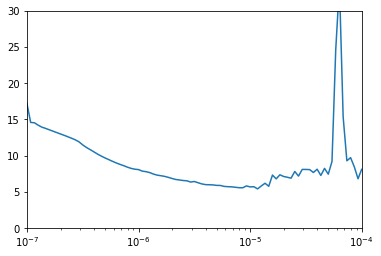

In [ ]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-7, 1e-4, 0, 30]);

Let's go with a learning rate of `5e-6`.

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)

In [ ]:
model = keras.Sequential([
  keras.layers.LSTM(units=100, return_sequences=True, input_shape=[None, 1]),
  keras.layers.LSTM(units=100, return_sequences=True),
  keras.layers.Dense(units=1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    'my_checkpoint.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
)

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=5e-6, momentum=0.9)

model.compile(
    loss=keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae']
)

In [ ]:
model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 5s 257ms/step - loss: 24.0806 - mae: 24.5771 - val_loss: 39.4315 - val_mae: 39.9306

Epoch 00001: val_loss improved from inf to 39.43150, saving model to my_checkpoint.h5
Epoch 2/500
8/8 [==============================] - 1s 159ms/step - loss: 17.2934 - mae: 17.7877 - val_loss: 22.8335 - val_mae: 23.3294

Epoch 00002: val_loss improved from 39.43150 to 22.83354, saving model to my_checkpoint.h5
Epoch 3/500
8/8 [==============================] - 1s 155ms/step - loss: 12.6601 - mae: 13.1503 - val_loss: 12.4972 - val_mae: 12.9842

Epoch 00003: val_loss improved from 22.83354 to 12.49715, saving model to my_checkpoint.h5
Epoch 4/500
8/8 [==============================] - 1s 155ms/step - loss: 9.7032 - mae: 10.1898 - val_loss: 11.6826 - val_mae: 12.1693

Epoch 00004: val_loss improved from 12.49715 to 11.68263, saving model to my_checkpoint.h5
Epoch 5/500
8/8 [==============================] - 1s 155ms/step - loss: 8.2547 - mae: 8.7398 - va

The early stopping callback didn't stop training (it went all the way to `500` epochs). This means that the model was still making progress on the validation loss. Presumably, if we increase the number of epochs to a higher value, the model will continue to improve.

In [ ]:
model = keras.models.load_model('my_checkpoint.h5')

In [ ]:
series_2d = series[..., np.newaxis]

series_2d

array([[ 62.48357077],
       [ 59.35127045],
       [ 63.30881273],
       ...,
       [ 91.87937625],
       [ 88.82580493],
       [132.30772008]])

In [ ]:
seq2seq_lstm_forecast = model_forecast(model, series_2d[split_time - window_size:-1], window_size)[:, -1, 0]

seq2seq_lstm_forecast.shape

(461,)

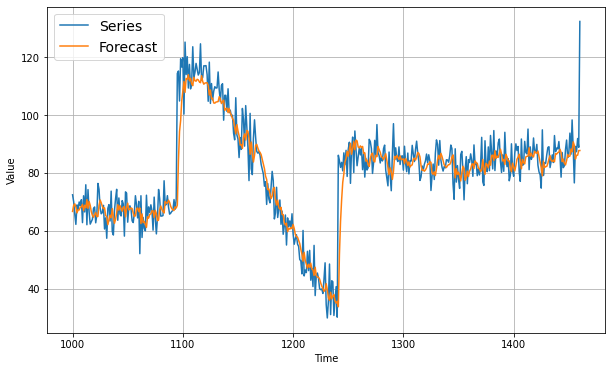

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label='Series')
plot_series(time_valid, seq2seq_lstm_forecast, label='Forecast')
plt.show()

In [ ]:
keras.metrics.mean_absolute_error(x_valid, seq2seq_lstm_forecast).numpy()

5.041288

## XXII. CNNs

The next architecture we're going to look at is ConvNets. In previous lessons, you've seen that ConvNets can be tremendously efficient for image processing tasks, such as image classification. Now, we'll see that they are also very efficient at handling sequences.

A 1D convolutional layer is exactly like a 2D convolutional layer, except that it slides filters (a.k.a. kernels) across just one dimension (typically the time axis in a time series) instead of sliding them across two dimensions (typically the height and width of an image).

For example, this is a simple 1D convolutional layer with a filter of size `3`. Since the filter size is `3`, each output is only computed based on `3` input time steps.

![](https://drive.google.com/uc?export=view&id=1PsD252smVMmZf1cSLMjCzWvp1ZWt6vmp)

In this example, the layer computes a weighted sum of the values at time steps 0, 1 & 2, adds a bias term, and then applies an activation function (typically ReLU). This gives the output at time step 1, i.e., $ReLU(w_0x_0 + w_1x_1 + w_2x_2 + b)$.

Then, the layer slides the filter across the input sequence.

![](https://drive.google.com/uc?export=view&id=15DrYDw_Rp2wTm2oFxqt81GJL7TDWfXpG)

The next output is computed based on the values at time steps 1, 2 & 3. The output at time step 2 is $ReLU(w_0x_1 + w_1x_2 + w_2x_3 + b)$.

Then, the layer slides the filter across the input sequence once again.

![](https://drive.google.com/uc?export=view&id=1GuH8WHEMLt7FCS_HcHxQD0Cazh281A-G)

The next output is computed based on the values at time steps 2, 3 & 4. The output at time step 3 is $ReLU(w_0x_2 + w_1x_3 + w_2x_4 + b)$.

And so on, until we reach the end of the input sequence.

Just like an RNN, a 1D convolutional layer can handle input sequences of ANY length. The number of parameters just depends on the kernel size and the number of  kernels, not on the length of the input sequence.

However, an RNN layer has some memory, whereas a 1D convolutional layer has no memory at all. Each output is computed based only on the small window of input time steps (which is determined by the size of the filter). This may seem like a very serious limitation, but as we will see, once you stack multiple 1D convolutional layers, the top layers (i.e., the last few layers) indirectly end up seeing a large part of the input sequence. So ConvNets can actually capture very long-term patterns.

Let's look at some of the hyperparameters we need to set when we define a 1D convolutional layer. They are very similar to the hyperparameters of a 2D convolutional layer.

First is the `kernel_size`. This is `3` in this example, but you can set it to a larger value if you want. However, just like in 2D ConvNets, it's often preferable to stack multiple convolutional layers (each with a small kernel) rather than to use a single convolutional layer with a large kernel. The amount of computations and parameters used when you stack multiple convolutional layers with small kernels is much smaller, and the network's ability to learn complex patterns is actually increased.

**Note:** A `Conv1D` layer applied to a multivariate time series is analogous to a `Conv2D` layer applied to a color image.





## XXIII. Padding

Another hyperparameter you need to set is the type of padding you want to use.

By default, there is no padding at all.

![](https://drive.google.com/uc?export=view&id=1s2FgmeWRcdY2t2hXKWfQY2qZUtT1EkuS)

This means that the output sequence will be slightly shorter than the input sequence. In this example, since the kernel size is `3`, the output sequence is two time steps shorter than the input sequence (one time step at the beginning and one time step at the end). That's $3 - 1$ time steps shorter. If the kernel size was `5`, the output sequence would be four time steps shorter than the input sequence (two time steps at the beginning and two time steps at the end). That's $5 - 1$ time steps shorter.

But if you set `padding='same'` when creating the 1D convolutional layer, then it will automatically pad the input sequence with enough zeros (left and right) to ensure that the output sequence has the same length as the input sequence. That's why it's called `'same'` padding.

![](https://drive.google.com/uc?export=view&id=1L5-jsuxL_RGy4sy1BU48qRESCTVqMl2o)

Another type of padding commonly used with 1D convolutional layers is called `'causal'` padding.

![](https://drive.google.com/uc?export=view&id=1QJNhy5uPqunOiFRGsqQEYDPn2PteIyw2)

Instead of padding zeros left and right of the input sequence, they are only padded on the left side (in the past). Just like with `'same'` padding, the output sequence has the same length as the input sequence, but now the output at time $t$ only depends on inputs at time $t$ or before (not on inputs after time $t$). When building a model for forecasting, it's essential to ensure that the model doesn't cheat by using future values to forecast future values. So `'causal'` padding is usually a good choice.

**Note:** In the above diagram, the output at time $t$ is (confusingly) positioned one time step ahead of the input at time $t$. For example, the output at time $0$ is positioned one time step ahead of the input at time $0$. But it should be positioned directly above.



## XXIV. Stride

Another hyperparameter you need to set is the stride.

**Note:** This is referring to the stride in 1D convolutional layers. In 2D convolutional layers, the default stride is `(1, 1)`. Don't confuse this with the the stride in max pooling layers.

By default, the stride is equal to `1`, meaning the filter slides by `1` time step at a time.

![](https://drive.google.com/uc?export=view&id=1b1HlMcM4BZFEQME0pfIqKzk_-Q2gQAiv)

But you can set this to a larger value if you want, e.g., `2`.

![](https://drive.google.com/uc?export=view&id=1nrDy3DjUelDAjmhNEaxAgzcwak8KEAFn)

In this case, the first output will be a function of the values at input time steps 0, 1 and 2 (assuming `'valid'` padding). The second output will be a function of the values at input time steps 2, 3 and 4.

And so on...

Notice that the output sequence now contains roughly half the number of time steps of the input sequence.

![](https://drive.google.com/uc?export=view&id=1UySpcPBVkmFfW0mWQNmdNHF4PSF3OfX8)

This can be useful to reduce the amount of computations, and shorten the time series (without losing too much useful information).

For example, you could use a convolutional layer with a stride of `2` to shorten the time series, and pass the resulting shorter sequence to an RNN. If the RNN did not have enough memory to capture long-term patterns in the original sequence, perhaps once the sequence is shortened, the RNN will perform better.

Also, a 1D convolutional layer may learn to perform something like a moving average, and remove a lot of the noise in the inputs (by lowering the frequency), which will of course help the RNN.

**Note:** The same result may be achieved by using a stride of `1` in the 1D convolutional layer, and adding an `AveragePooling1D` or `MaxPool1D` layer with a pool size of `2` and a stride of `2`.

In short, you can use 1D convolutional layers as preprocessing layers before an RNN, which can improve its performance.

## XXV. Kernels

Lastly, you need to specify the number of filters you want the 1D convolutional layer to use.

In the following example, there are `2` filters (each with its own weights and bias term).

![](https://drive.google.com/uc?export=view&id=1rx2Kl06UBhEFtx95aYx4S2xv1hFXIeMo)


The output sequence will have `2` values at each time step. In other words, the output sequence's dimensionality will be `2` (i.e., **it will be a multivariate time series**).

The number of filters to use is something you have to tune. If you set it too low, the model will likely perform poorly. But if you set it too high, it will likely overfit the training set, and generalize poorly.

The following is an example of a model that uses a 1D convolutional layer to preprocess the input sequence before passing it on to an LSTM layer.

```
model = keras.Sequential([
  keras.layers.Conv1D(
    filters=32,
    kernel_size=5,
    strides=1,
    padding='causal',
    activation='relu',
    input_shape=[None, 1]
  ),
  keras.layers.LSTM(units=32, return_sequences=True),
  keras.layers.LSTM(units=32, return_sequences=True),
  keras.layers.Dense(units=1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
```

The `Conv1D` layer can learn to detect short-term patterns that are most useful for the RNN.

## XXVI. WaveNet

**Note:** The WaveNet architecture is not explained in detail in this section (it is merely glossed over.) So, for now, don't try to understand every aspect of it. However, feel free to use the code as a template in your projects.

It's actually possible to handle sequences using convolutional layers only (without any recurrent layers). In fact, using ConvNets for sequence processing is becoming increasingly popular (for both time series and NLP).

One example is the WaveNet architecture proposed by DeepMind in 2016.

**Slide 1:**

![](https://drive.google.com/uc?export=view&id=1DMXTF-Jka4GJkcYWkMcskgNjLbgsSlt4)

**Slide 2:**

![](https://drive.google.com/uc?export=view&id=1XI3c8cVV3mz91NZQy7uYeMgx3Q4IfPbf)

**Note:** The last output of Slide 1 has been added to the input sequence in Slide 2.

**Slide 3:**

![](https://drive.google.com/uc?export=view&id=1VVHnuKyEce_0yY9BtffuyKl2M4j8fhKZ)

**Slide 4:**

![](https://drive.google.com/uc?export=view&id=1xaQPKPY8q2H2R9nokFSPqwgShxUsVxSR)

**Note:** The last output of Slide 3 has been added to the input sequence in Slide 4.

**Slide 5:**

![](https://drive.google.com/uc?export=view&id=1GQL5HF_fNWmxOCVjwdleu0RKgq1lDY0x)

Every layer is a 1D convolutional layer with `kernel_size=2`, `strides=1`, `padding='causal'`, and `activation='relu'`.

However, the second convolutional layer uses a *dilation rate* of `2`, meaning that it skips every other input time step. The third convolutional layer uses a dilation rate of `4`, meaning that it skips three time steps out of four. The fourth convolutional layer uses a dilation rate of `8`, meaning that it skips seven time steps out of eight. And so on... The dilation rate doubles at every layer.

This way, the lower layers can learn short-term patterns, while the higher layers learn long-term patterns. For example, each output of the third convolutional layer is a function of $2^3 = 8$ consecutive time steps. The fourth layer is a function of $2^4 = 16$ consecutive time steps. This is called the layer's *receptive field*. Each convolutional layer we add doubles the receptive field. (In this case, the receptive field of a layer is double the dilation rate of that layer.)

**Note:** Keep this is mind when deciding on the number of convolutional layers.

The following is the Keras code to create a simple WaveNet like model.

**Note:** Just like RNNs, WaveNet takes a 3 dimensional tensor as input having shape [batch size, # time steps, # dims]. Moreover, WaveNet takes a sequence-to-sequence window dataset as input.

```
model = keras.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
  model.add(
    keras.layers.Conv1D(
      filters=32,
      kernel_size=2,
      strides=1,
      dilation_rate=dilation_rate,
      padding='causal',
      activation='relu'
    )
  )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1, strides=1))
```

It is composed of six 1D convolutional layers with the dilation rate doubling at each layer, and a final 1D convolutional layer with a single kernel of size `1` and stride `1`. The last layer is equivalent to a dense layer. At each time step, it will take the `32` inputs from the previous layer (corresponding to each of the `32` filters), perform a linear combination, and output a single value. **Note:** This is akin to how the `3` color channels in a color image are convolved separately, and then combined into a single convoluted image (in the first `Conv2D` layer, assuming it has just `1` filter).

If we train this model on windows of `64` time steps (which is the size of this model's receptive field since $2^6 = 64$), we get the following forecasts.

![](https://drive.google.com/uc?export=view&id=1la8GtVvCHf758mRy3MZpuqWSMblAo7Jh)

The forecasts look pretty good! The MAE is about 4.6. At last we've found a model which performs as well as the last moving average solution (without having to de-trend and de-seasonalize the time series)!





## XXVII. Colab: Forecasting with CNNs

### Preprocessing with a 1D Convolutional Layer

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

In [ ]:
model = keras.Sequential([
  keras.layers.Conv1D(
      filters=32,
      kernel_size=5,
      strides=1,
      padding='causal',
      activation='relu',
      input_shape=[None, 1]
  ),
  keras.layers.LSTM(units=32, return_sequences=True),
  keras.layers.LSTM(units=32, return_sequences=True),
  keras.layers.Dense(units=1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

In [ ]:
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

model.compile(
    loss=keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae']
)

In [ ]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 41ms/step - loss: 88.8481 - mae: 89.3477
Epoch 2/100
8/8 [==============================] - 0s 33ms/step - loss: 88.8822 - mae: 89.3818
Epoch 3/100
8/8 [==============================] - 0s 34ms/step - loss: 87.3846 - mae: 87.8842
Epoch 4/100
8/8 [==============================] - 0s 29ms/step - loss: 86.3332 - mae: 86.8328
Epoch 5/100
8/8 [==============================] - 0s 34ms/step - loss: 83.9856 - mae: 84.4853
Epoch 6/100
8/8 [==============================] - 0s 34ms/step - loss: 81.8656 - mae: 82.3652
Epoch 7/100
8/8 [==============================] - 0s 34ms/step - loss: 78.9472 - mae: 79.4468
Epoch 8/100
8/8 [==============================] - 0s 26ms/step - loss: 75.7864 - mae: 76.2860
Epoch 9/100
8/8 [==============================] - 0s 35ms/step - loss: 73.7301 - mae: 74.2298
Epoch 10/100
8/8 [==============================] - 0s 35ms/step - loss: 71.0544 - mae: 71.5539
Epoch 11/100
8/8 [==============================]

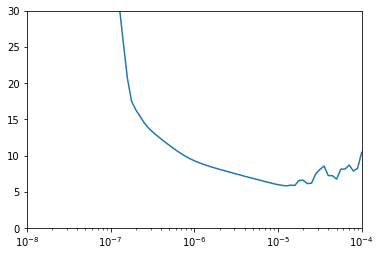

In [ ]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30]);

Let's go with a learning rate of `1e-5` (even though it's a bit risky).

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)

In [ ]:
model = keras.Sequential([
  keras.layers.Conv1D(
      filters=32,
      kernel_size=5,
      strides=1,
      padding='causal',
      activation='relu',
      input_shape=[None, 1]
  ),
  keras.layers.LSTM(units=32, return_sequences=True),
  keras.layers.LSTM(units=32, return_sequences=True),
  keras.layers.Dense(units=1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    'my_checkpoint.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
)

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model.compile(
    loss=keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae']
)

In [ ]:
model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 5s 216ms/step - loss: 71.2540 - mae: 71.7531 - val_loss: 26.7414 - val_mae: 27.2365

Epoch 00001: val_loss improved from inf to 26.74142, saving model to my_checkpoint.h5
Epoch 2/500
8/8 [==============================] - 1s 58ms/step - loss: 28.4834 - mae: 28.9798 - val_loss: 30.1406 - val_mae: 30.6384

Epoch 00002: val_loss did not improve from 26.74142
Epoch 3/500
8/8 [==============================] - 1s 55ms/step - loss: 16.5906 - mae: 17.0850 - val_loss: 26.1872 - val_mae: 26.6851

Epoch 00003: val_loss improved from 26.74142 to 26.18722, saving model to my_checkpoint.h5
Epoch 4/500
8/8 [==============================] - 1s 56ms/step - loss: 12.7223 - mae: 13.2135 - val_loss: 23.8257 - val_mae: 24.3227

Epoch 00004: val_loss improved from 26.18722 to 23.82569, saving model to my_checkpoint.h5
Epoch 5/500
8/8 [==============================] - 1s 54ms/step - loss: 10.8518 - mae: 11.3407 - val_loss: 18.5835 - val_mae: 19.0771

Epoc

In [ ]:
model = keras.models.load_model('my_checkpoint.h5')

In [ ]:
series_2d = series[..., np.newaxis]

series_2d

array([[ 62.48357077],
       [ 59.35127045],
       [ 63.30881273],
       ...,
       [ 91.87937625],
       [ 88.82580493],
       [132.30772008]])

In [ ]:
seq2seq_cnn_lstm_forecast = model_forecast(model, series_2d[split_time - window_size:-1], window_size)[:, -1, 0]

seq2seq_cnn_lstm_forecast.shape

(461,)

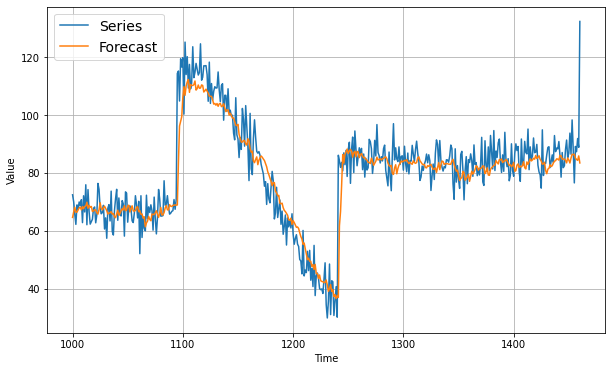

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label='Series')
plot_series(time_valid, seq2seq_cnn_lstm_forecast, label='Forecast')
plt.show()

In [ ]:
keras.metrics.mean_absolute_error(x_valid, seq2seq_cnn_lstm_forecast).numpy()

5.1788316

These forecasts are worse than our previous LSTM network forecasts.

### WaveNet

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
window_size = 64 # THIS IS EQUAL TO THE RECEPTIVE FIELD OF THE MODEL.
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

In [ ]:
model = keras.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
  model.add(
      keras.layers.Conv1D(
          filters=32,
          kernel_size=2,
          strides=1,
          dilation_rate=dilation_rate,
          padding='causal',
          activation='relu'
      )
  )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1, strides=1))

**Note:** The last `Conv1D` layer doesn't require padding because the kernel size is `1`.

In [ ]:
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30)
)

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

model.compile(
    loss=keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae']
)

In [ ]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 51ms/step - loss: 44.2027 - mae: 44.7017
Epoch 2/100
8/8 [==============================] - 1s 42ms/step - loss: 43.3535 - mae: 43.8523
Epoch 3/100
8/8 [==============================] - 0s 43ms/step - loss: 44.1319 - mae: 44.6308
Epoch 4/100
8/8 [==============================] - 0s 43ms/step - loss: 43.6355 - mae: 44.1345
Epoch 5/100
8/8 [==============================] - 0s 44ms/step - loss: 42.8031 - mae: 43.3021
Epoch 6/100
8/8 [==============================] - 0s 45ms/step - loss: 42.0678 - mae: 42.5667
Epoch 7/100
8/8 [==============================] - 1s 43ms/step - loss: 40.1625 - mae: 40.6609
Epoch 8/100
8/8 [==============================] - 0s 32ms/step - loss: 39.3466 - mae: 39.8457
Epoch 9/100
8/8 [==============================] - 0s 41ms/step - loss: 36.4491 - mae: 36.9477
Epoch 10/100
8/8 [==============================] - 0s 43ms/step - loss: 31.1949 - mae: 31.6930
Epoch 11/100
8/8 [==============================]

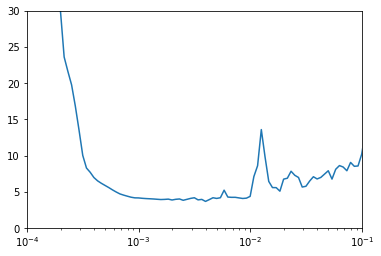

In [ ]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-4, 1e-1, 0, 30]);

Let's go with a learning rate of `1e-3`.

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)

In [ ]:
model = keras.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
  model.add(
      keras.layers.Conv1D(
          filters=32,
          kernel_size=2,
          strides=1,
          dilation_rate=dilation_rate,
          padding='causal',
          activation='relu'
      )
  )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1, strides=1))

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    'my_checkpoint.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
)

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    loss=keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae']
)

In [ ]:
model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 2s 172ms/step - loss: 41.1172 - mae: 41.6160 - val_loss: 61.4762 - val_mae: 61.9762

Epoch 00001: val_loss improved from inf to 61.47618, saving model to my_checkpoint.h5
Epoch 2/500
8/8 [==============================] - 1s 62ms/step - loss: 30.0319 - mae: 30.5298 - val_loss: 33.9538 - val_mae: 34.4517

Epoch 00002: val_loss improved from 61.47618 to 33.95380, saving model to my_checkpoint.h5
Epoch 3/500
8/8 [==============================] - 1s 63ms/step - loss: 21.6354 - mae: 22.1311 - val_loss: 29.5194 - val_mae: 30.0167

Epoch 00003: val_loss improved from 33.95380 to 29.51938, saving model to my_checkpoint.h5
Epoch 4/500
8/8 [==============================] - 1s 68ms/step - loss: 17.7369 - mae: 18.2305 - val_loss: 23.1520 - val_mae: 23.6462

Epoch 00004: val_loss improved from 29.51938 to 23.15202, saving model to my_checkpoint.h5
Epoch 5/500
8/8 [==============================] - 1s 69ms/step - loss: 13.4014 - mae: 13.8914 - val

In [ ]:
model = keras.models.load_model('my_checkpoint.h5')

In [ ]:
series_2d = series[..., np.newaxis]

series_2d

array([[ 62.48357077],
       [ 59.35127045],
       [ 63.30881273],
       ...,
       [ 91.87937625],
       [ 88.82580493],
       [132.30772008]])

In [ ]:
wavenet_forecast = model_forecast(model, series_2d[split_time - window_size:-1], window_size)[:, -1, 0]

wavenet_forecast.shape

(461,)

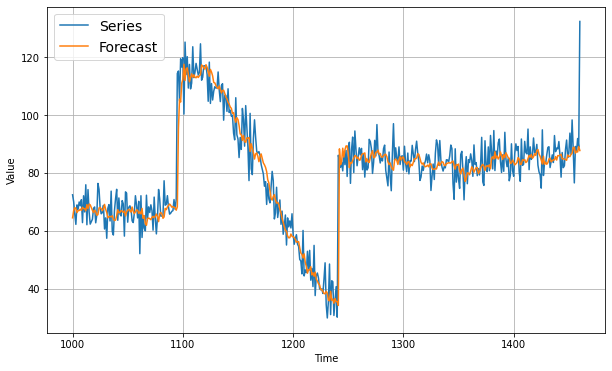

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label='Series')
plot_series(time_valid, wavenet_forecast, label='Forecast')
plt.show()

In [ ]:
keras.metrics.mean_absolute_error(x_valid, wavenet_forecast).numpy()

4.657418

As you can see, the best model we've found is a fully convolutional neural network having the WaveNet architecture. In many cases, you'll find that CNNs actually outperform RNNs. So when you're dealing with sequence data, RNNs may be the way to go in some cases, but not always. And you should definitely try out CNNs.

## XXVIII. Outro

I hope you enjoyed this introduction to time series forecasting using deep learning. If you want to dig deeper, you can check out my book.

We covered a lot of ground focusing on ML techniques. But there are many other techniques you can use such as ARIMA (which often outperform ML techniques).

As always, try to practice your newly acquired skills as much as possible. I wish you a lot of fun and success in predicting the future.